In [1]:
import numpy as np 
import nibabel as nib 
import matplotlib.pyplot as plt 
import nilearn.plotting as niplt
%matplotlib inline 
import os 
import seaborn as sns 
from scipy.special import softmax 
from scipy.stats import ttest_rel
import pandas as pd 

In [2]:
story='black'
roi_mapping=np.load('/jukebox/griffiths/bert-brains/'+story+'_data/Parcel2ROI_new.npy')
list(set(roi_mapping))

[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 20.0,
 21.0,
 22.0]

In [21]:
#excluded 296 (less <25% comprehension score)
#Temporary exclusion: 'sub-292', 'sub-311', 'sub-267', 'sub-295', 'sub-305', 'sub-274' 
black_subs=['sub-300', 'sub-304', 'sub-293', 'sub-273', 'sub-265', 'sub-307', 'sub-283', 'sub-275', 
'sub-291', 'sub-297', 'sub-303', 'sub-294', 'sub-286', 'sub-282', 'sub-310', 'sub-302', 'sub-312', 
'sub-301', 'sub-287', 'sub-298', 'sub-313', 'sub-285', 'sub-290', 'sub-288', 'sub-281', 'sub-276', 'sub-277', 'sub-299', 'sub-308',
'sub-272', 'sub-284', 'sub-289', 'sub-280', 'sub-309', 'sub-306', 'sub-127', 'sub-279', 
'sub-315', 'sub-314','sub-292', 'sub-311', 'sub-267', 'sub-295', 'sub-305', 'sub-274'] 
slumlordreach_subs=['sub-145', 'sub-143', 'sub-016', 'sub-142', 'sub-141', 'sub-133', 'sub-140', 'sub-136', 
'sub-084', 'sub-135', 'sub-137', 'sub-138', 'sub-111', 'sub-106', 'sub-134', 'sub-132', 'sub-144']
rois=['PostTemp','AntTemp','AngG','IFG','MFG','IFGorb','vmPFC','dmPFC','PMC','HG','V1']
#rois=['HG','PostTemp','AntTemp','AngG','IFG','IFGorb','MFG','vmPFC','dmPFC','PMC']
roi_names=['L_'+roi for roi in rois]+['R_'+roi for roi in rois] 
def permutation_pvalue(x,y):
    orig=np.abs(np.median(x-y))
    diffs=x-y
    perms=[]
    for _ in range(1000):
        perms.append(np.median(diffs*np.random.choice([-1,1],size=len(diffs),replace=True))) 
    if np.sum(np.abs(perms)>=orig)==0:
        return 1.0/1000.0
    else:
        return np.sum(np.abs(perms)>=orig)/1000.0
def bootstrap_CI(x):
    m=x.mean()
    boots=[]
    for _ in range(10000):
        samp=np.concatenate([np.random.choice(x[:45],size=len(x[:45]),replace=True),np.random.choice(x[45:],size=len(x[45:]),replace=True)])
        boots.append(np.mean(samp))
    return np.percentile(boots,(2.5,97.5))
def bootstrap_pvalue(x):
    m=np.median(x)
    x=x-m
    boots=[] 
    for _ in range(1000):
        samp=np.concatenate([np.random.choice(x[:45],size=len(x[:45]),replace=True),np.random.choice(x[45:],size=len(x[45:]),replace=True)])
        boots.append(np.median(samp))
    if np.sum(boots>=m)==0:
        return 1.0/10000.0
    else:
        return np.sum(boots>=m)/10000.0
def p_adjust_bh(p):
    """Benjamini-Hochberg p-value correction for multiple hypothesis testing."""
    p = np.asfarray(p)
    by_descend = p.argsort()[::-1]
    by_orig = by_descend.argsort()
    steps = float(len(p)) / np.arange(len(p), 0, -1)
    q = np.minimum(1, np.minimum.accumulate(steps * p[by_descend]))
    return q[by_orig] 

def softmax(x, tau=1.0):
    e_x = np.exp(x / tau)
    return e_x / e_x.sum()
def get_result_dataset(dataset,rep_name,normalize_isc=True):
    results=[]
    for story in dataset:
        results_story=[]
        if story=='black':
            subs=black_subs
        if story=='slumlordreach':
            subs=slumlordreach_subs
        if 'syntactic' in rep_name:
            result_dir='/jukebox/griffiths/bert-brains/results/'+story+"/encoding-"+story+"_"+rep_name+"/"
        elif 'ling' in rep_name or 'glove' in rep_name or 'magnitude' in rep_name:
            result_dir='/jukebox/griffiths/bert-brains/results/'+story+"/encoding-"+rep_name+"/"
        elif 'full' in rep_name:
            result_dir='/jukebox/griffiths/bert-brains/results/'+story+"/encoding_"+rep_name+"/"
        else:
            result_dir='/jukebox/griffiths/bert-brains/results/'+story+"/"+rep_name+"/"
        roi_mapping=np.load('/jukebox/griffiths/bert-brains/'+story+'_data/Parcel2ROI_new.npy')
        roi_mapping[np.where(roi_mapping)==22]=11 
        for sub in subs:
            #results_sub_parcels=np.load(result_dir+sub+"_parcelwise_results.npy")
            #noise_ceiling_parcels=np.load('/jukebox/griffiths/bert-brains/'+story+"_data/isc/"+sub+'.npy')

            results_sub_parcels=np.arctanh(np.load(result_dir+sub+"_parcelwise_results_banded_ridge.npy")[:,3])
            noise_ceiling_parcels=np.arctanh(np.load('/jukebox/griffiths/bert-brains/'+story+"_data/isc/"+sub+'.npy'))
            results_sub_parcels[np.isnan(results_sub_parcels)]=0.0
            noise_ceiling_parcels[np.isnan(noise_ceiling_parcels)]=0.0
            results_sub=np.zeros((22,))
            noise_sub=np.zeros((22,))
            
            for roi in range(22):
                results_sub[roi]=results_sub_parcels[np.where(roi_mapping==roi+1)].mean() 
                noise_sub[roi]=noise_ceiling_parcels[np.where(roi_mapping==roi+1)].mean()
            #results_story.append(-1*np.log(results_sub/noise_sub))
            if normalize_isc:
                r=(results_sub/noise_sub)*100.0 
                r[r>100.0]=100.0
                results_story.append(r)
            else:
                results_story.append((results_sub))
        results_story=np.asarray(results_story)
        results.append(results_story)
    results=np.asarray(results)
    results=np.concatenate(results,axis=0)
    results[np.isnan(results)]=0.0
    return results 

In [18]:
def get_result_dataset(dataset,rep_name,normalize_isc=True):
    results=[]
    for story in dataset:
        results_story=[]
        if story=='black':
            subs=black_subs
        if story=='slumlordreach':
            subs=slumlordreach_subs
        if 'syntactic' in rep_name:
            result_dir='/jukebox/griffiths/bert-brains/results/'+story+"/encoding-"+story+"_"+rep_name+"/"
        elif 'ling' in rep_name or 'glove' in rep_name or 'magnitude' in rep_name:
            result_dir='/jukebox/griffiths/bert-brains/results/'+story+"/encoding-"+rep_name+"/"
        elif 'full' in rep_name:
            result_dir='/jukebox/griffiths/bert-brains/results/'+story+"/encoding_"+rep_name+"/"
        else:
            result_dir='/jukebox/griffiths/bert-brains/results/'+story+"/"+rep_name+"/"
        roi_mapping=np.load('/jukebox/griffiths/bert-brains/'+story+'_data/Parcel2ROI_new.npy')
        for sub in subs:
            #results_sub_parcels=np.load(result_dir+sub+"_parcelwise_results.npy")
            #noise_ceiling_parcels=np.load('/jukebox/griffiths/bert-brains/'+story+"_data/isc/"+sub+'.npy')

            results_sub_parcels=np.arctanh(np.load(result_dir+sub+"_parcelwise_results_banded_ridge.npy")[:,3])
            noise_ceiling_parcels=np.arctanh(np.load('/jukebox/griffiths/bert-brains/'+story+"_data/isc/"+sub+'.npy'))
            results_sub_parcels[np.isnan(results_sub_parcels)]=0.0
            noise_ceiling_parcels[np.isnan(noise_ceiling_parcels)]=0.0
            results_sub=results_sub_parcels
            noise_sub=noise_ceiling_parcels 
            
            
            #results_story.append(-1*np.log(results_sub/noise_sub))
            if normalize_isc:
                r=(results_sub/noise_sub)*100.0 
                r[r>100.0]=100.0
                results_story.append(r)
            else:
                results_story.append((results_sub))
        results_story=np.asarray(results_story)
        results.append(results_story)
    results=np.asarray(results)
    results=np.concatenate(results,axis=0)
    results[np.isnan(results)]=0.0
    return results 

In [17]:
from scipy.stats import entropy 
layers=np.asarray([get_result_dataset(['black','slumlordreach'],'encoding-layer_'+str(i)+'_activations') for i in range(13)])

zs=np.asarray([get_result_dataset(['black','slumlordreach'],'encoding-layer_'+str(i)+'_z_representations') for i in range(12)])
layers.mean

/usr/people/sreejank/anaconda3/envs/fmri/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


0.7252224278094977

In [10]:
np.save('')

0

In [5]:
layer_performance.shape 

(62, 22)

In [36]:
bootstrap_CI(glove_performance[:,(10,21)].mean(axis=1))

array([ 0.59889459, 38.32193781])

/usr/people/sreejank/anaconda3/envs/fmri/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


(-5, 35)

<Figure size 432x288 with 0 Axes>

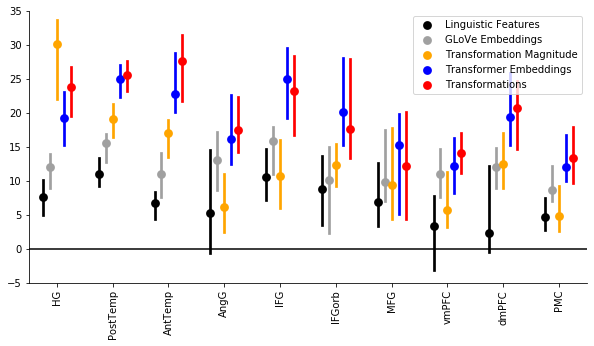

In [26]:
#Figure 1: All representation performances

attention_scores_performance=get_result_dataset(['black','slumlordreach'],'zrep_magnitudes')
ling_features_performance=get_result_dataset(['black','slumlordreach'],'ling_features')
glove_performance=get_result_dataset(['black','slumlordreach'],'glove')
layer_performance=get_result_dataset(['black','slumlordreach'],'full')
z_performance=get_result_dataset(['black','slumlordreach'],'full_z')


reps=[ling_features_performance,glove_performance,attention_scores_performance,layer_performance,z_performance]
roi=[]
performance=[]
rep_name=[]
rep_names=['Linguistic Features','GLoVe Embeddings','Transformation Magnitude','Transformer Embeddings','Transformations']
for k in range(len(rep_names)):
    example_layer=reps[k]
    for i in range(example_layer.shape[0]):
        for j in range(11):
            roi.append(rois[j%11])
            rep_name.append(rep_names[k])
            r=example_layer[i,j]
            if r<-100:
                r=-100
            performance.append(r)
roi=np.asarray(roi)
performance=np.asarray(performance)
rep_name=np.asarray(rep_name)
df=pd.DataFrame(dict(performance=performance,roi=roi,rep=rep_name))
plt.figure()
pal=sns.mpl_palette('tab10',n_colors=10)
#pal2=sns.mpl_palette('nipy_spectral',n_colors=len(rep_names))
pal2_cols=['#000000','#A0A0A0','#FFA500','#0000ff','#ff0000','#ff9999']
pal2=sns.color_palette(pal2_cols)

o=['HG','PostTemp','AntTemp','AngG','IFG','IFGorb','MFG','vmPFC','dmPFC','PMC']
#o=['V1']
#v=sns.violinplot(data=df,x='roi',y='performance',zorder=0,inner=None,linewidth=1,cut=0,hue='roi',alpha=0.2)
#sns.stripplot(data=df.sort_values('performance'),x='roi',y='performance',hue='rep',dodge=0.5,zorder=1,size=2,palette=pal2,order=['HG','PostTemp','AntTemp','AngG','IFG',
#'IFGorb','MFG','vmPFC','dmPFC','PMC'],alpha=0.1,hue_order=rep_names)
plt.figure(figsize=(10,5))
sns.pointplot(data=df.sort_values('performance'),x='roi',y='performance',hue='rep',dodge=0.5,join=False,ci=95,n_boot=10000,zorder=2,alpha=0.5,palette=pal2,order=o,capsize=0,hue_order=rep_names,estimator=np.median)
#sns.boxplot(x='roi',y='performance',data=df,saturation=0.35,fliersize=0)
plt.xticks(rotation=90)
#plt.legend(['L','R'],['C0','C1'])
plt.axhline(y=0,color='black')
ax=plt.gca()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:6], labels[:])
sns.despine(top=True,right=True,left=False,bottom=False)
my_colors=['C'+str(i) for i in range(10)]
#for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), my_colors):
#    ticklabel.set_color(tickcolor)
plt.xlabel("")
plt.ylabel("")
plt.ylim(-5,35)
#for i in range(10):
#    plt.axvline(x=i+0.5,color='black',linestyle='--')
#plt.savefig('plots/fig4_1/v1_right.svg',format='svg')#
#plt.savefig('fig1data_right.svg',format='svg')

Text(0.5, 1.0, 'Performance of Transformations Minux Performance of Layers')

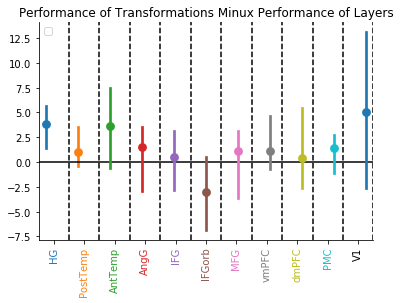

In [15]:
diffs=z_performance-layer_performance


roi=[]
performance=[]
for i in range(diffs.shape[0]):
    for j in range(11):
        roi.append(rois[j])
        performance.append(diffs[i,j])
df=pd.DataFrame(dict(roi=roi,performance=performance))
pal=sns.mpl_palette('tab10',n_colors=10)

#v=sns.violinplot(data=df,x='roi',y='performance',zorder=0,inner=None,linewidth=1,cut=0,hue='roi',alpha=0.2)
#sns.stripplot(data=df.sort_values('performance'),x='roi',y='performance',hue='rep',dodge=0.5,zorder=1,size=2,palette=pal2,order=['HG','PostTemp','AntTemp','AngG','IFG',
#'IFGorb','MFG','vmPFC','dmPFC','PMC'],alpha=0.1,hue_order=rep_names)
sns.pointplot(data=df.sort_values('performance'),x='roi',y='performance',hue='roi',dodge=0.5,join=False,ci=95,n_boot=10000,zorder=2,alpha=0.5,palette=pal,order=['HG','PostTemp','AntTemp','AngG','IFG',
'IFGorb','MFG','vmPFC','dmPFC','PMC','V1'],capsize=0,estimator=np.median,hue_order=['HG','PostTemp','AntTemp','AngG','IFG',
'IFGorb','MFG','vmPFC','dmPFC','PMC','V1'])
#sns.boxplot(x='roi',y='performance',data=df,saturation=0.35,fliersize=0)
plt.xticks(rotation=90)
#plt.legend(['L','R'],['C0','C1'])
plt.axhline(y=0,color='black')
ax=plt.gca()
handles, labels = ax.get_legend_handles_labels()
ax.legend([])
sns.despine(top=True,right=True,left=False,bottom=False)
my_colors=['C'+str(i) for i in range(10)]
for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), my_colors):
    ticklabel.set_color(tickcolor)
plt.xlabel("")
plt.ylabel("")
for i in range(11):
    plt.axvline(x=i+0.5,color='black',linestyle='--')
plt.title("Performance of Transformations Minux Performance of Layers")


In [11]:
layer_performance.shape 

(62, 22)

0
1
2
3
4
5
6
7
8
9
10


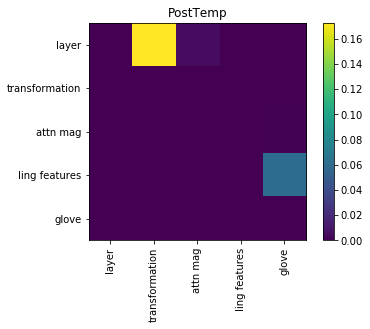

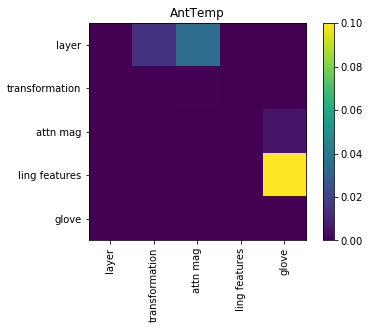

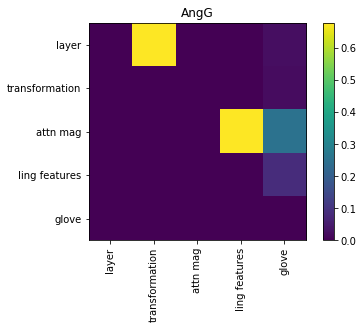

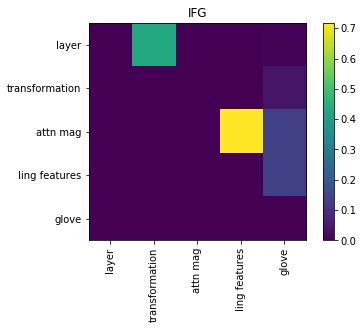

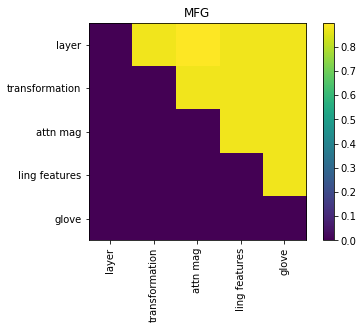

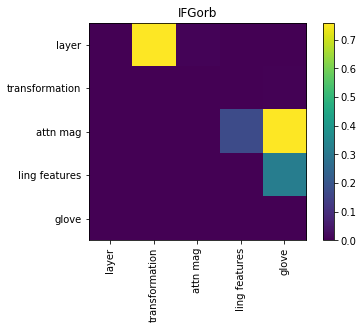

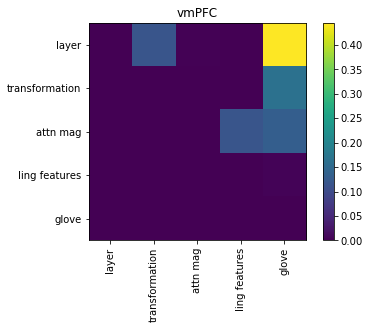

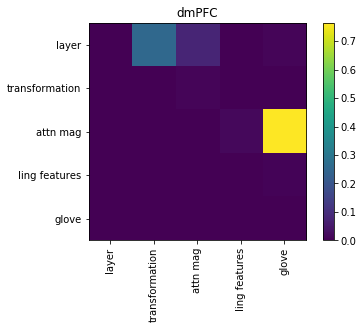

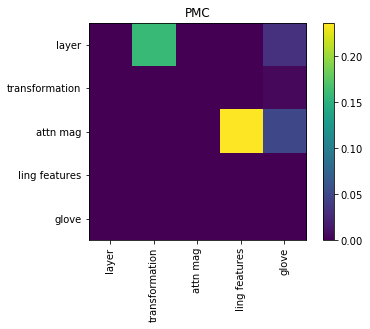

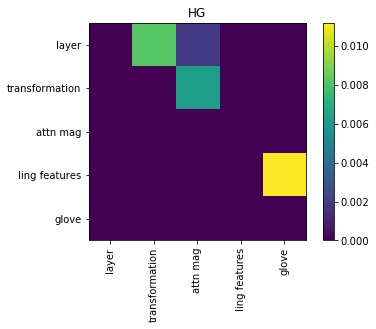

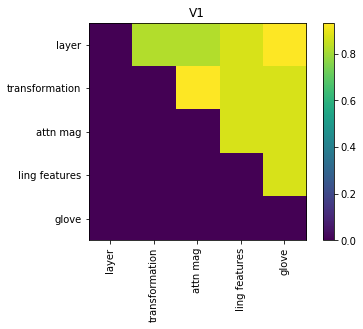

In [19]:
#Transformations vs Embeddings - Everything
from scipy.stats import ttest_rel
perm_p=[]
ts=[]
roi=[]
reps=[layer_performance,z_performance,attention_scores_performance,ling_features_performance,glove_performance]
names=['layer','transformation','attn mag','ling features','glove']

for i in range(11):
    print(i)
    p_values=np.zeros((5,5))
    for j in range(5):
        for k in range(5):
            #p_values[j,k]=permutation_pvalue(reps[j][:,i],reps[k][:,i])
            p_values[j,k]=ttest_rel(reps[j][:,i],reps[k][:,i])[1]
    all_p=p_adjust_bh(p_values[np.triu(np.ones((5,5)),k=1).astype('bool')].flatten())
    #all_p=p_values[np.triu(np.ones((5,5)),k=1).astype('bool')].flatten()
    new_p=np.zeros((5,5))
    new_p[np.triu(np.ones((5,5)),k=1).astype('bool')]=all_p 
    perm_p.append(new_p)
    plt.figure()
    plt.imshow(new_p)
    plt.xticks(list(range(5)),names,rotation=90)
    plt.yticks(list(range(5)),names)
    plt.title(rois[i])
    plt.colorbar()
perm_p=np.asarray(perm_p)

In [20]:
perm_p 

array([[[0.00000000e+00, 1.72574648e-01, 5.97018756e-03, 5.62128804e-11,
         1.00020098e-10],
        [0.00000000e+00, 0.00000000e+00, 5.24469199e-05, 6.72644959e-11,
         4.41550689e-10],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.45179829e-06,
         9.19128132e-04],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         6.07567529e-02],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00]],

       [[0.00000000e+00, 1.45276743e-02, 3.59689651e-02, 3.08541994e-09,
         2.60840736e-07],
        [0.00000000e+00, 0.00000000e+00, 4.91555369e-04, 2.64778092e-10,
         4.24404734e-08],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.77315545e-04,
         5.73290494e-03],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         1.00114730e-01],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00]],

      

In [22]:
final_p_values=np.round(perm_p,5)
table=np.zeros((10,11))
comps=[(0,1),(0,2),(0,3),(0,4),(1,2),(1,3),(1,4),(2,3),(2,4),(3,4)]
for comp in range(10):
    for roi in range(11):
        a,b=comps[comp]
        table[comp,:]=final_p_values[:,a,b]

np.savetxt('p_values.csv',table,delimiter=',')

In [11]:
#Attention Scores vs Linguistic Features - Everything
from scipy.stats import ttest_rel
boot_p=[]
perm_p=[]
t_p=[]
ts=[]
roi=[]



for i in range(11):
    x=attention_scores_performance[:,i]
    y=ling_features_performance[:,i]
    roi.append(rois[i])
    boot_p.append(bootstrap_pvalue(x-y))
    perm_p.append(permutation_pvalue(x,y))
    t,p=ttest_rel(x,y)
    print(t,p)
    t_p.append(np.round(p,3))
    ts.append(np.round(t,3))
df=pd.DataFrame(dict(roi=roi,ts=ts,t_p=t_p,perm_p=perm_p,boot_p=boot_p))
df

-0.5097810741709051 0.6120443607253323
-0.17269442339399582 0.8634633529890745
0.22925167404282626 0.8194402357257567
-2.5352708951658864 0.013815654035244233
1.3413326549711315 0.18478525338791935
1.0624962301436813 0.2921988039730462
0.6063618361405692 0.5465245343370211
0.2974049664284845 0.7671678370772149
-1.2444545169052308 0.21809267141650954
0.7933898000457817 0.4306261089529366
-1.2645485047565763 0.21084342532451547


,roi,ts,t_p,perm_p,boot_p
0,PostTemp,-0.510,0.612,0.2854,0.0987
1,AntTemp,-0.173,0.863,0.7529,0.0197
2,AngG,0.229,0.819,0.3827,0.0003
3,IFG,-2.535,0.014,0.1658,0.0931
4,IFGorb,1.341,0.185,0.3127,0.0237
5,MFG,1.062,0.292,0.9481,0.0516
6,vmPFC,0.606,0.547,0.6895,0.0485
7,dmPFC,0.297,0.767,0.8431,0.0560
8,PMC,-1.244,0.218,0.8326,0.0688
9,HG,0.793,0.431,0.4726,0.0247


/usr/people/sreejank/anaconda3/envs/fmri/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


[]

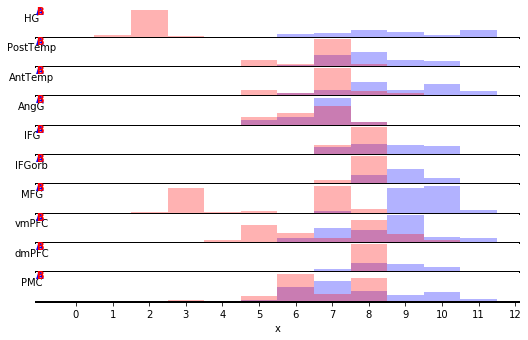

In [51]:
#Softmax Plot
layerwise=np.mean(np.asarray([get_result_dataset(['black','slumlordreach'],'encoding-layer_'+str(i)+"_activations") for i in range(1,13)]),axis=1)
zwise=np.mean(np.asarray([get_result_dataset(['black','slumlordreach'],'encoding-layer_'+str(i)+"_z_representations") for i in range(12)]),axis=1)

x=[]
g=[]
l=[]
v=[]
for roi in range(11):
    p=softmax(layerwise[:,roi],tau=1) 
    p2=softmax(zwise[:,roi],tau=1)
    #points=np.random.choice(np.arange(12),size=10000,p=p)
    #points2=np.random.choice(np.arange(12),size=10000,p=p2)
    points_val=[]
    points2_val=[]
    
    points=[]
    points2=[]
    for i in range(len(p)):
        points.append(np.ones((int(p[i]*10000),))*i)
        points2.append(np.ones((int(p2[i]*10000),))*i)
    points=np.concatenate(points)
    points2=np.concatenate(points2)
    sz=min(len(points2),len(points))
    for i in range(len(points)):
        v.append(p[points[i].astype('int')])
        x.append(points[i])
        g.append(roi_names[roi])
        l.append("A")
    for i in range(len(points2)):
        v.append(p2[points2[i].astype('int')])
        x.append(points2[i])
        g.append(roi_names[roi])
        l.append("B")
x=np.asarray(x)
g=np.asarray(g)
v=np.asarray(v)
#g = np.tile(roi_names, n_points)
df = pd.DataFrame(dict(x=x,g=g,l=l,v=v))
plt.rcParams['patch.edgecolor'] = 'none'
shuffle_labels=[0,5,7,9,3,5,1,2,4,6,8,10]
order=np.asarray(['L_'+x for x in ['HG','PostTemp','AntTemp','AngG','IFG',
'IFGorb','MFG','vmPFC','dmPFC','PMC']])

colors=list(sns.mpl_palette('tab10',n_colors=10).as_hex())+['#000000']
pal=sns.color_palette(np.asarray(colors))
#pal2=sns.mpl_palette('twilight_shifted',n_colors=2)
pal2=sns.color_palette(['blue','red'])
g = sns.FacetGrid(df, row="g", hue="l", aspect=15, height=0.5, palette=pal2,row_order=order,sharey=False,sharex=True)


g.map(sns.histplot, "x", discrete=True,alpha=0.3)
#g.map(sns.histplot, "x",kde=True)
#g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw_adjust=2)
#g.map(plt.axhline, y=0, lw=2, clip_on=False,color=pal)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .9, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "x")

#g.set_axis_labels("")
# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.0009)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(xticks=list(range(0,13)))
g.set(yticks=[]) 
g.despine(bottom=True, left=True)
for i in range(10):
    roi_name=order[i][2:]
    ii=rois.index(roi_name)
    p=softmax(layerwise[:,ii],tau=1) 
    p2=softmax(zwise[:,ii],tau=1)
    points=[]
    points2=[]
    for j in range(len(p)):
        points.append(np.ones((int(p[j]*10000),))*j)
        points2.append(np.ones((int(p2[j]*10000),))*j)
    points=np.concatenate(points)
    points2=np.concatenate(points2)
    #g.axes[i,0].axvline(x=np.median(points),color=pal2[0])
    #g.axes[i,0].axvline(x=np.median(points2),color=pal2[1])
    g.axes[i,0].set_ylabel(order[i%11][2:],rotation=0)
    g.axes[i,0].yaxis.label.set_color('black')
    g.axes[i,0].axhline(y=0,lw=2,clip_on=False,color='black')
g.axes[9,0].set_yticklabels(list(range(1,12)))
     
#plt.savefig('plots/fig2_1/left_hemi_softmax_plot.svg',format='svg')


In [52]:
#Entropies
layerwise=np.asarray([get_result_dataset(['black','slumlordreach'],'encoding-layer_'+str(i)+"_activations") for i in range(1,13)])
zwise=np.asarray([get_result_dataset(['black','slumlordreach'],'encoding-layer_'+str(i)+"_z_representations") for i in range(12)])
def entropy(ps):
    logged=np.log2(ps)
    logged[np.isnan(logged)]=0.0
    return -np.sum(ps*np.log2(ps))
layer_entropies=np.zeros((11,62))
z_entropies=np.zeros((11,62))
for i in range(11):
    for j in range(62):
        layer_entropies[i,j]=entropy(softmax(layerwise[:,j,i],tau=1.0))
        z_entropies[i,j]=entropy(softmax(zwise[:,j,i],tau=1.0))
layer_entropies[np.isnan(layer_entropies)]=0.0
z_entropies[np.isnan(z_entropies)]=0.0


boot_p=[]
perm_p=[]
t_p=[]
ts=[]
roi=[]
mean_embedding_entropy=[]
mean_transformation_entropy=[]
for i in range(10):
    x=layer_entropies[i,:]
    y=z_entropies[i,:]
    roi.append(rois[i])
    mean_embedding_entropy.append(x.mean())
    mean_transformation_entropy.append(y.mean())
    boot_p.append(bootstrap_pvalue(x-y))
    perm_p.append(permutation_pvalue(x,y))
    t,p=ttest_rel(x,y)
    print(t,p)
    t_p.append(np.round(p,3))
    ts.append(np.round(t,3))
boot_p=p_adjust_bh(np.asarray(boot_p))
df=pd.DataFrame(dict(roi=roi,mean_embedding_entropy=mean_embedding_entropy,mean_transformation_entropy=mean_transformation_entropy,t_stat=ts,p_value=boot_p))
df.to_csv('entropies.csv')
df

/usr/people/sreejank/anaconda3/envs/fmri/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/people/sreejank/anaconda3/envs/fmri/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: overflow encountered in exp
/usr/people/sreejank/anaconda3/envs/fmri/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in true_divide
/usr/people/sreejank/anaconda3/envs/fmri/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log2
  """
/usr/people/sreejank/anaconda3/envs/fmri/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log2
  

5.125880242737372 3.227475743266283e-06
6.663590136202195 8.743541764786058e-09
2.63549418240527 0.01063781430057745
4.213727565959092 8.429498890936166e-05
3.0046077238056856 0.0038545819004378494
3.356345640828025 0.0013636716099243579
3.9752169964917123 0.00018878433289635114
5.210097810649386 2.3600519618696235e-06
3.6036180543379963 0.0006322228171788028
4.432208667084656 3.952645207045612e-05


,roi,mean_embedding_entropy,mean_transformation_entropy,t_stat,p_value
0,PostTemp,1.213017,0.682410,5.126,0.000200
1,AntTemp,0.967747,0.386166,6.664,0.000200
2,AngG,0.635415,0.384404,2.635,0.013667
3,IFG,0.849935,0.379699,4.214,0.002286
4,MFG,0.642895,0.390109,3.005,0.013667
5,IFGorb,0.710396,0.387391,3.356,0.014900
6,vmPFC,0.819666,0.416128,3.975,0.000200
7,dmPFC,0.767067,0.374110,5.210,0.000200
8,PMC,1.005454,0.611965,3.604,0.000333
9,HG,1.067142,0.511295,4.432,0.000200


In [4]:
def permutation_pvalue(x):
    orig=np.mean(x)
    perms=[]
    for _ in range(10):
        perms.append(np.mean(x*np.random.choice([-1,1],size=len(x),replace=True))) 
    perms=np.asarray(perms)
    if np.sum(perms>=orig)==0:
        return 1.0/10.0
    else:
        return np.sum(perms>=orig)/10.0
    
#Head Analyses
results=[]
for story in ['black','slumlordreach']:
    results_story=[]
    if story=='black':
        subs=black_subs
    if story=='slumlordreach':
        subs=slumlordreach_subs
    result_dir='/jukebox/griffiths/bert-brains/results/'+story+"/encoding_headwise/"
    roi_mapping=np.load('/jukebox/griffiths/bert-brains/'+story+'_data/Parcel2ROI.npy')
    for sub in subs:
        if os.path.exists(result_dir+sub+"_parcelwise_results.npy"):
            #results_sub_parcels=np.load(result_dir+sub+"_parcelwise_results.npy")
            #noise_ceiling_parcels=np.load('/jukebox/griffiths/bert-brains/'+story+"_data/isc/"+sub+'.npy')
            results_sub_parcels=np.arctanh(np.load(result_dir+sub+"_parcelwise_results_banded_ridge.npy"))
            print(results_sub_parcels.shape)
            noise_ceiling_parcels=np.arctanh(np.load('/jukebox/griffiths/bert-brains/'+story+"_data/isc/"+sub+'.npy'))
            results_sub=np.zeros((20,144))
            for roi in range(20):
                results_sub[roi]=(results_sub_parcels[np.where(roi_mapping==roi+1)].mean(axis=0)/noise_ceiling_parcels[np.where(roi_mapping==roi+1)].mean())
                results_sub[roi]=results_sub[roi]*100.0
            #results_story.append(-1*np.log(results_sub/noise_sub))
            results_story.append(results_sub)
    results_story=np.asarray(results_story)
    results.append(results_story)
results=np.concatenate(results,axis=0)
results[np.isnan(results)]=0.0

roi_names=['PostTemp','AntTemp','AngG','IFG','MFG','IFGorb','vmPFC','dmPFC','PMC','HG']

#decoding_black=np.load('data/decoding_results_indiv_bert-base-uncased_black_logistic_3_train_balanced_score_balanced.npz')
#decoding_slumlord=np.load('data/decoding_results_indiv_bert-base-uncased_slumlordreach_logistic_3_train_balanced_score_balanced.npz')
decoding_black=np.load('data/decoding_results_indiv_bert-base-uncased_black_logistic_5_5_train_balanced_score_balanced_nested_liblinear.npz')
decoding_slumlord=np.load('data/decoding_results_indiv_bert-base-uncased_slumlordreach_logistic_5_5_train_balanced_score_balanced_nested_liblinear.npz')
dependencies=['prep','pobj','det','nsubj','amod','dobj','advmod','aux','poss','ccomp','mark','prt']

brain_results=results.mean(axis=0)[:10,:]

p_values=np.zeros((10,144))
for roi in range(10):
    print(roi)
    for head in range(144):
        p_values[roi,head]=permutation_pvalue(results[:,roi,head])
p_values=p_adjust_bh(p_values.flatten()).reshape((10,144))


head_name=[]
brain_predictivity=[]
roi=[]
dependency_predictivity=[]
dependency=[]
top3=[]
top3_coords=np.zeros((10,len(dependencies),3,3))
layer=[]
significant=[]
headwise_corr_data=np.zeros((len(dependencies),len(roi_names),144,2))
for head in list(range(144)):
    head_label=str(head//12+1)+"-"+str(head-(head//12)*12+1)
    for i in range(len(dependencies)):
        for j in range(len(roi_names)):
            roi.append(roi_names[j])
            brain_predictivity.append(brain_results[j,head])
            head_name.append(head_label)
            dep=dependencies[i]
            dependency.append(dep)
            idx=int(list(decoding_black['labels']).index(dep))
            black_acc=decoding_black['acc'][:,:,idx].flatten()
            idx=int(list(decoding_slumlord['labels']).index(dep))
            slum_acc=decoding_slumlord['acc'][:,:,idx].flatten()
            mean_dep_acc=np.mean([black_acc,slum_acc],axis=0)[head]
            dependency_predictivity.append(mean_dep_acc)

            top_idx=np.argsort(brain_results[j,:])[::-1][:3]
            significant.append(int(p_values[j,head]<.05))
            if head in top_idx:
                loc=np.where(top_idx==head)[0][0]
                top3.append(loc+2)
                top3_coords[j,i,loc,0]=mean_dep_acc
                top3_coords[j,i,loc,1]=brain_results[j,head]
                top3_coords[j,i,loc,2]=head
                

            elif int(p_values[j,head]<.05):
                top3.append(1)
            else:
                top3.append(0)
            if int(p_values[j,head]<.05):
                layer.append(head//12+1)
                headwise_corr_data[i,j,head,0]=mean_dep_acc
                headwise_corr_data[i,j,head,1]=brain_results[j,head]
            else:
                layer.append(0)
                #headwise_corr_data[i,j,head,0]=-9999
                #headwise_corr_data[i,j,head,1]=-9999
                headwise_corr_data[i,j,head,0]=mean_dep_acc
                headwise_corr_data[i,j,head,1]=brain_results[j,head]
            



df=pd.DataFrame(dict(head=head_name,layer=layer,brain_predictivity=brain_predictivity,roi=roi,dependency_predictivity=dependency_predictivity,dependency=dependency,significant=significant,top3=top3))

from scipy.stats import spearmanr
def correlation(x,y):
    orig=spearmanr(x,y)[0]
    null=[]
    shuffle=x.copy()
    for _ in range(1000):
        np.random.shuffle(shuffle)
        null.append(spearmanr(shuffle,y)[0])
    null=np.asarray(null)
    p=max(1/1000.0,np.sum(null>=orig)/1000,0)
    return orig,p 

def p_adjust_bh(p):
    """Benjamini-Hochberg p-value correction for multiple hypothesis testing."""
    p = np.asfarray(p)
    by_descend = p.argsort()[::-1]
    by_orig = by_descend.argsort()
    steps = float(len(p)) / np.arange(len(p), 0, -1)
    q = np.minimum(1, np.minimum.accumulate(steps * p[by_descend]))
    return q[by_orig]
    
head_corrs=np.zeros((len(dependencies),len(roi_names)))
head_pvalues=np.zeros((len(dependencies),len(roi_names)))
for i in range(len(dependencies)):
    for j in range(len(roi_names)):
        x=headwise_corr_data[i,j,:,0]
        y=headwise_corr_data[i,j,:,1] 
        #x=x[x>-9999]
        #y=y[y>-9999]
        r,p=spearmanr(x,y)
        head_corrs[i,j]=r
        head_pvalues[i,j]=p 
head_pvalues=p_adjust_bh(head_pvalues.flatten()).reshape(head_pvalues.shape)




(1000, 144)
(1000, 144)
(1000, 144)
(1000, 144)
(1000, 144)
(1000, 144)
(1000, 144)
(1000, 144)
(1000, 144)
(1000, 144)
(1000, 144)
(1000, 144)
(1000, 144)
(1000, 144)
(1000, 144)
(1000, 144)
(1000, 144)
(1000, 144)
(1000, 144)
(1000, 144)
(1000, 144)
(1000, 144)
(1000, 144)
(1000, 144)
(1000, 144)
(1000, 144)
(1000, 144)
(1000, 144)
(1000, 144)
(1000, 144)
(1000, 144)
(1000, 144)
(1000, 144)
(1000, 144)
(1000, 144)
(1000, 144)
(1000, 144)
(1000, 144)
(1000, 144)
(1000, 144)
(1000, 144)
(1000, 144)
(1000, 144)
(1000, 144)
(1000, 144)
(1000, 144)
(1000, 144)
(1000, 144)
(1000, 144)
(1000, 144)
(1000, 144)
(1000, 144)
(1000, 144)
(1000, 144)
(1000, 144)
(1000, 144)
(1000, 144)
(1000, 144)
(1000, 144)
(1000, 144)
(1000, 144)
(1000, 144)
0
1
2
3
4
5
6
7
8
9


In [35]:
layerwise.shape 

(12, 62, 22)

In [12]:
np.load(result_dir+sub+"_parcelwise_results_banded_ridge.npy")[20]

array([ 0.03039   ,  0.06415529,  0.05330987,  0.01539659, -0.00494164,
        0.01649158,  0.01528006, -0.02731131, -0.02077485, -0.04353214,
       -0.03058472,  0.00223197,  0.01095416,  0.04254936,  0.05519153,
       -0.04632917,  0.0209295 ,  0.0848386 , -0.0205839 ,  0.00228839,
       -0.02868457,  0.06387073,  0.02013206, -0.03064354,  0.06961924,
        0.01130191,  0.0268647 , -0.03527606,  0.03422656,  0.03607403,
       -0.04233329, -0.06620158, -0.00948017,  0.01331379,  0.09047382,
        0.02285284, -0.02145613, -0.00305452, -0.11580663, -0.17655258,
       -0.03626881, -0.06088152, -0.01020695, -0.00032563,  0.01179546,
       -0.10912374, -0.07664273, -0.0497948 ,  0.04250319,  0.06648994,
        0.08686538, -0.02877086, -0.0311521 , -0.01471342,  0.0476634 ,
        0.00718494,  0.0518669 , -0.08306363,  0.05223898, -0.03485286,
        0.02285192,  0.03552198,  0.046197  ,  0.01474452,  0.05000799,
        0.04737721,  0.03976474,  0.08856024, -0.06607157, -0.03

([<matplotlib.axis.XTick at 0x7ffa20975b50>,
 <a list of 12 Text xticklabel objects>)

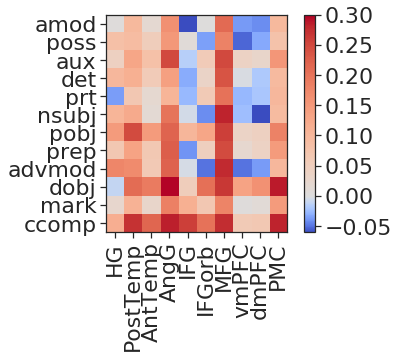

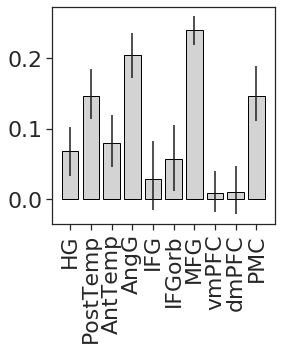

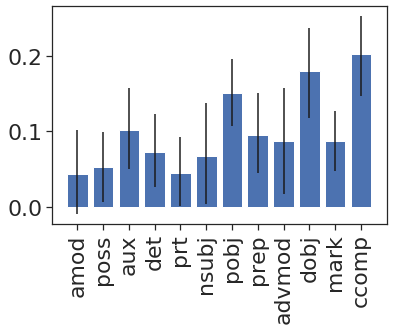

In [45]:
#Head Analyses 2
def bootstrap_errors(data):
    m=data.mean()
    boots=[]
    for _ in range(10000):
        boots.append(np.mean(np.random.choice(data,size=len(data),replace=True)))
    ci=np.asarray(np.percentile(boots,(2.5,97.5)))
    return np.abs(ci-m)

dep_distance_black=np.load('data/dep_dist_freq_all_black.npz')
dep_distance_black=[dep_distance_black[dep].mean() for dep in dependencies]

dep_distance_slumlord=np.load('data/dep_dist_freq_all_slumlordreach.npz')
dep_distance_slumlord=[dep_distance_slumlord[dep].mean() for dep in dependencies]

dep_distance=np.mean([dep_distance_slumlord,dep_distance_black],axis=0)
rois=['PostTemp','AntTemp','AngG','IFG','MFG','IFGorb','vmPFC','dmPFC','PMC','HG','V1']
dep_order=np.argsort(dep_distance)

roi_order=np.asarray([9,0,1,2,3,5,4,6,7,8]).astype('int')
corrs=head_corrs.copy()[dep_order,:]
corrs=corrs[:,roi_order]
roi_names2=np.asarray(rois)[roi_order]
dependencies_neword=np.asarray(dependencies)[dep_order]
dependencies2=[]
for i,d in enumerate(dependencies_neword):
    #dependencies2.append(d+" ("+str(np.round(dep_distance[dep_order][i],3))+")")
    dependencies2.append(d)

fig=plt.figure(figsize=(6,4))
from matplotlib import colors 
divnorm=colors.DivergingNorm(vmin=-.06, vcenter=0., vmax=0.3)
plt.imshow(corrs,cmap='coolwarm',norm=divnorm)
plt.xticks(list(range(10)),roi_names2,rotation=90)
plt.yticks(list(range(12)),dependencies2)
plt.colorbar() 
plt.savefig('plots/combined_heatmap.svg',format='svg')
fig=plt.figure(figsize=(4,4))
plt.bar(list(range(10)),corrs.mean(axis=0),yerr=np.asarray([bootstrap_errors(corrs[:,i]) for i in range(10)]).T,color='lightgrey',edgecolor='black')
plt.xticks(list(range(10)),roi_names2,rotation=90)
plt.savefig('plots/marginals.svg',format='svg')
plt.figure()
plt.bar(list(range(12)),corrs.mean(axis=1),yerr=np.asarray([bootstrap_errors(corrs[i,:]) for i in range(12)]).T)
plt.xticks(list(range(12)),dependencies2,rotation=90)

In [43]:
roi_names

['PostTemp',
 'PostTemp',
 'PostTemp',
 'PostTemp',
 'PostTemp',
 'PostTemp',
 'PostTemp',
 'PostTemp',
 'PostTemp',
 'PostTemp',
 'PostTemp',
 'PostTemp',
 'PostTemp',
 'PostTemp',
 'PostTemp',
 'PostTemp',
 'PostTemp',
 'PostTemp',
 'PostTemp',
 'PostTemp',
 'PostTemp',
 'PostTemp',
 'PostTemp',
 'PostTemp',
 'PostTemp',
 'PostTemp',
 'PostTemp',
 'PostTemp',
 'PostTemp',
 'PostTemp',
 'PostTemp',
 'PostTemp',
 'PostTemp',
 'PostTemp',
 'PostTemp',
 'PostTemp',
 'PostTemp',
 'PostTemp',
 'PostTemp',
 'PostTemp',
 'PostTemp',
 'PostTemp',
 'PostTemp',
 'PostTemp',
 'PostTemp',
 'PostTemp',
 'PostTemp',
 'PostTemp',
 'PostTemp',
 'PostTemp',
 'PostTemp',
 'PostTemp',
 'PostTemp',
 'PostTemp',
 'PostTemp',
 'PostTemp',
 'PostTemp',
 'PostTemp',
 'PostTemp',
 'PostTemp',
 'PostTemp',
 'PostTemp',
 'PostTemp',
 'PostTemp',
 'PostTemp',
 'PostTemp',
 'PostTemp',
 'PostTemp',
 'PostTemp',
 'PostTemp',
 'PostTemp',
 'PostTemp',
 'PostTemp',
 'PostTemp',
 'PostTemp',
 'PostTemp',
 'PostTemp',

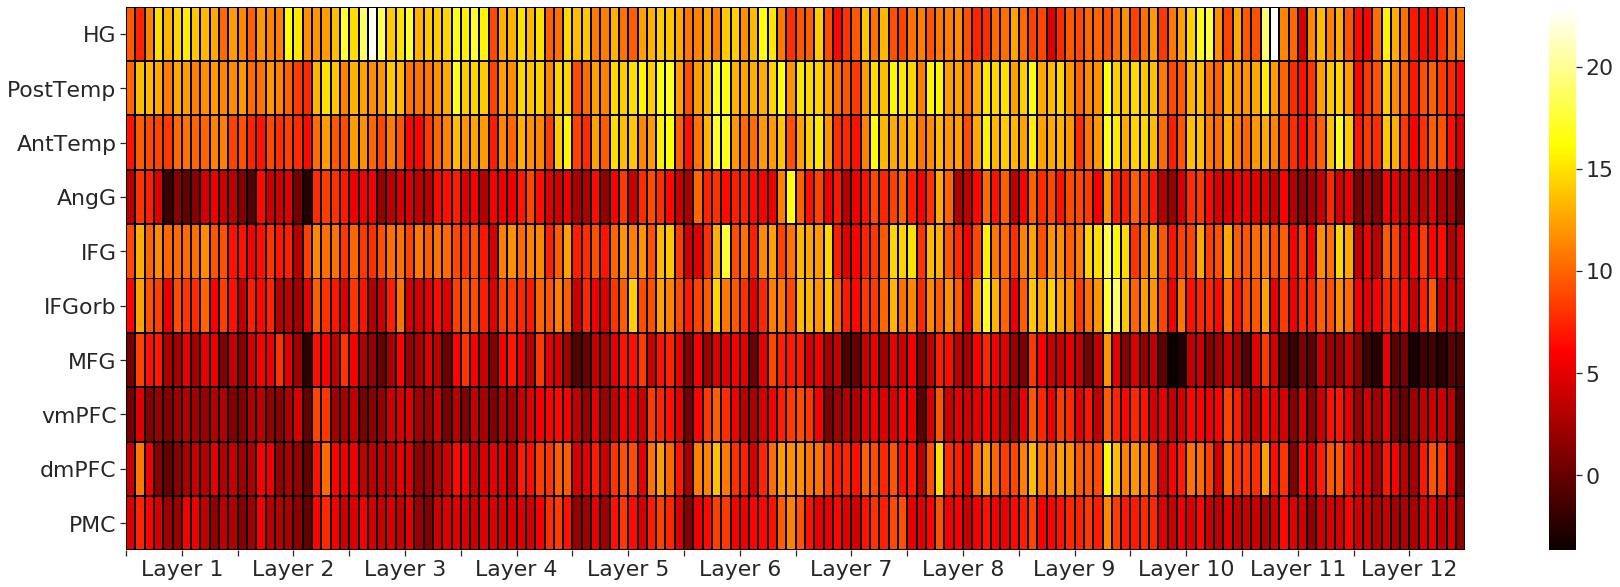

In [107]:
full_encoding_mat=np.zeros((len(roi_names),144))
full_decoding_mat=np.zeros((len(dependencies),144))
roi_names=['PostTemp','AntTemp','AngG','IFG','MFG','IFGorb','vmPFC','dmPFC','PMC','HG']
for i in range(len(dependencies)):
    for j in range(len(roi_names)):
        x=headwise_corr_data[i,j,:,0]
        y=headwise_corr_data[i,j,:,1]
        full_encoding_mat[j,:]=y
        full_decoding_mat[i,:]=x 
full_encoding_mat=full_encoding_mat[roi_order,:]
full_decoding_mat=full_decoding_mat[dep_order,:]
"""
plt.figure(figsize=(30,5))
sns.heatmap(full_encoding_mat,cmap='hot')
plt.yticks(list(range(10)),roi_names2)
plt.xticks(list(range(0,144,12)))
plt.colorbar()
plt.savefig('plots/encoding_heatmap.svg',format='svg')
"""
df=pd.DataFrame(full_encoding_mat,columns=list(range(144)))
plt.figure(figsize=(30,10))
sns.heatmap(df,cmap='hot',xticklabels=12,linecolor='black',linewidths=1)
plt.yticks(ticks=np.asarray(list(range(10)))+0.5,labels=np.asarray(roi_names)[roi_order],rotation=0)
tick_labels=[]
idx=1
for t in list(range(0,144,6)):
    if t%6==0 and t%12!=0:
        tick_labels.append('Layer '+str(idx))
        idx+=1
    else:
        tick_labels.append('')
plt.xticks(ticks=np.asarray(list(range(0,144,6))),labels=tick_labels)
#df 
plt.savefig('plots/encoding_heatmap.svg',format='svg')


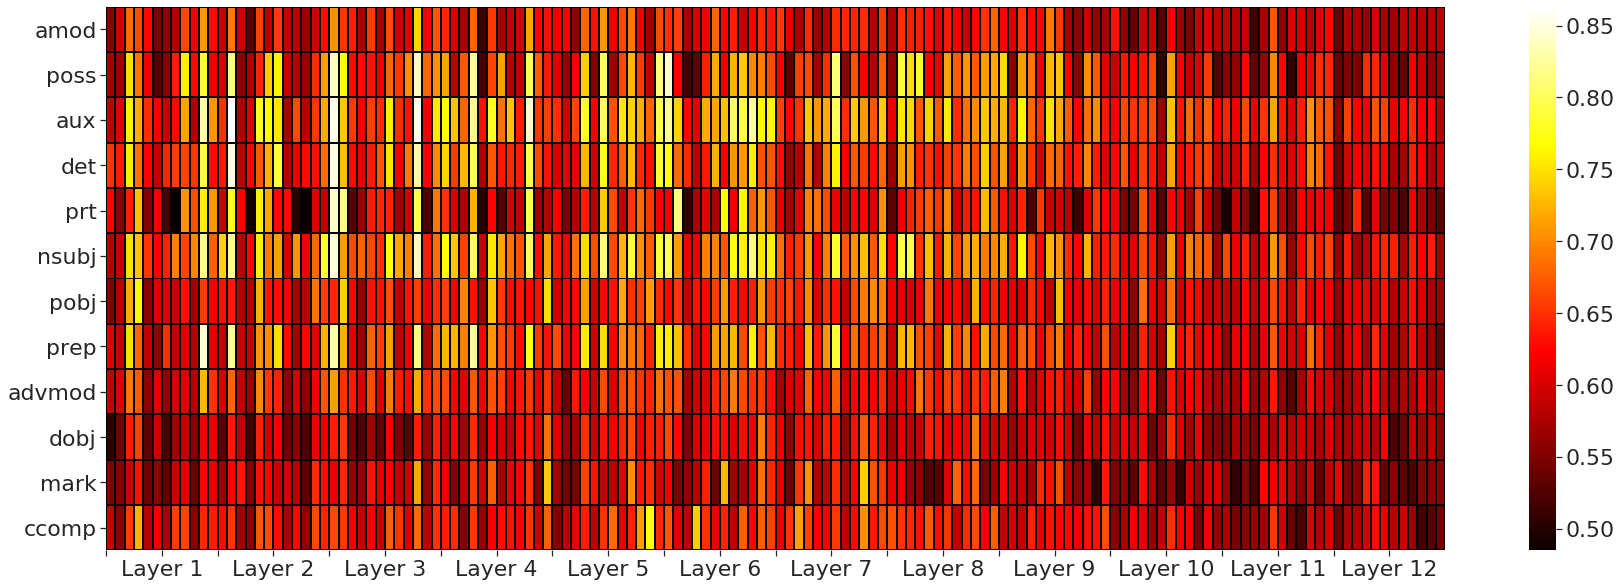

In [106]:
df=pd.DataFrame(full_decoding_mat,columns=list(range(144)))
plt.figure(figsize=(30,10))
sns.heatmap(df,cmap='hot',xticklabels=12,linecolor='black',linewidths=1)
plt.yticks(ticks=np.asarray(list(range(12)))+0.5,labels=dependencies2,rotation=0)
tick_labels=[]
idx=1
for t in list(range(0,144,6)):
    if t%6==0 and t%12!=0:
        tick_labels.append('Layer '+str(idx))
        idx+=1
    else:
        tick_labels.append('')
plt.xticks(ticks=np.asarray(list(range(0,144,6))),labels=tick_labels)
#df 
plt.savefig('plots/decoding_heatmap.svg',format='svg')

In [74]:
list(range(0,144,12))

[0, 12, 24, 36, 48, 60, 72, 84, 96, 108, 120, 132]

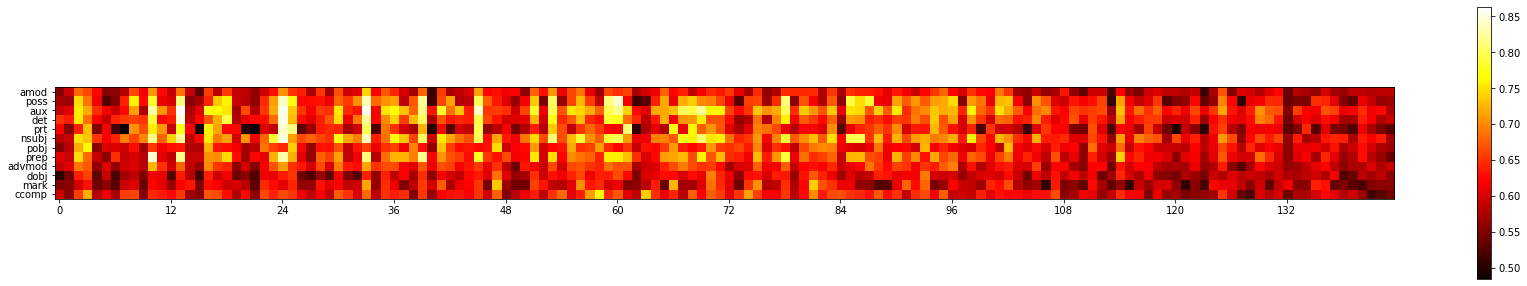

In [18]:
plt.figure(figsize=(30,5))
plt.imshow(full_decoding_mat,cmap='hot')
plt.yticks(list(range(12)),dependencies2)
plt.xticks(list(range(0,144,12)))
plt.colorbar()
plt.savefig('plots/decoding_heatmap.svg')

In [33]:
np.save('data/full_encoding_heatmap_attn_scores.npy',full_encoding_mat)

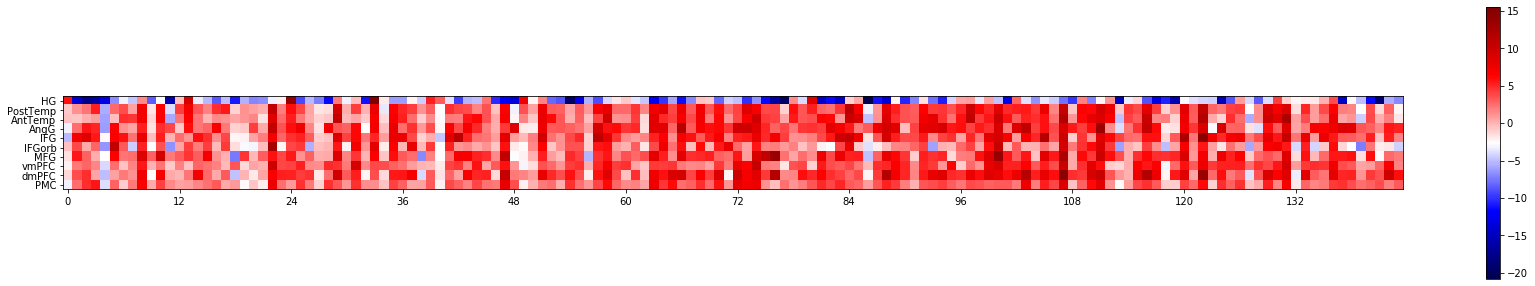

In [148]:
z_encoding=np.load('data/full_encoding_heatmap_z.npy')
attn_score_encoding=np.load('data/full_encoding_heatmap_attn_scores.npy')
plt.figure(figsize=(30,5))
plt.imshow(z_encoding-attn_score_encoding,cmap='seismic')
plt.yticks(list(range(10)),roi_names2)
plt.xticks(list(range(0,144,12)))
plt.colorbar()

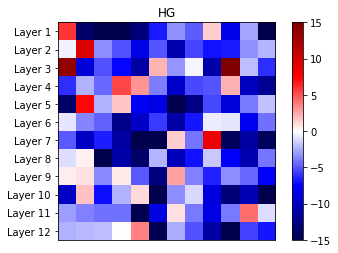

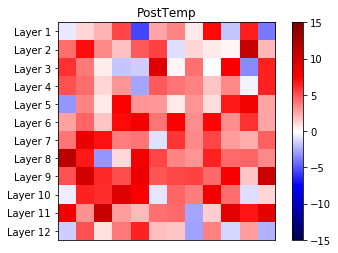

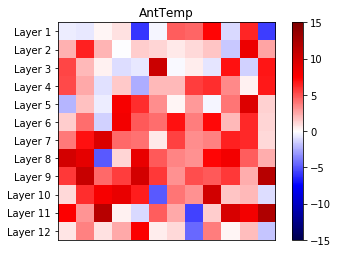

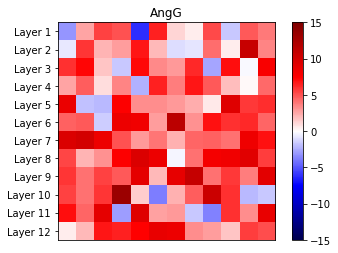

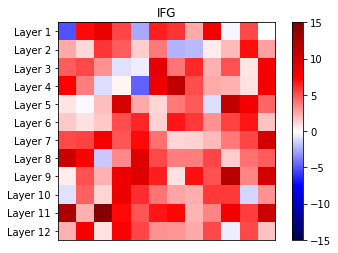

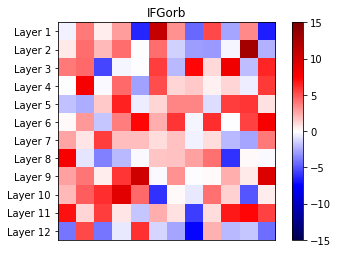

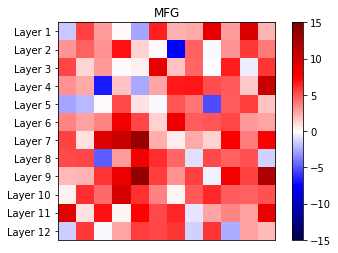

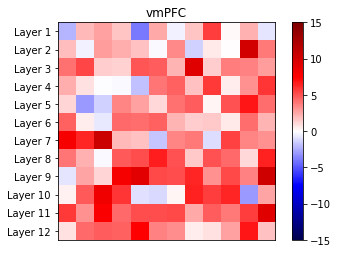

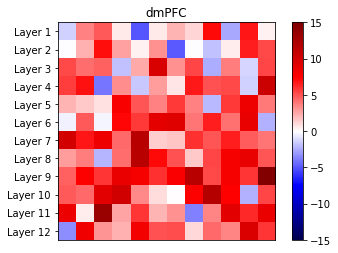

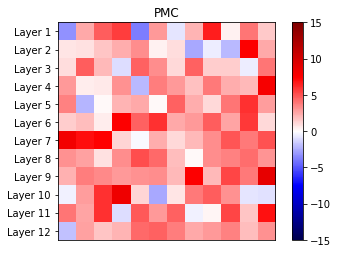

In [160]:
from matplotlib import colors 
#divnorm=colors.TwoSlopeNorm(vmin=-15., vcenter=0., vmax=15)
x=z_encoding-attn_score_encoding
for i in range(10):
    plt.figure()
    plt.imshow(x[i].reshape((12,12)),cmap='seismic',vmin=-15,vmax=15)
    plt.colorbar()
    plt.title(roi_names2[i])
    plt.yticks(list(range(12)),["Layer "+str(i) for i in range(1,13)])
    plt.xticks([])

In [26]:
dependencies,rois 

(['prep',
  'pobj',
  'det',
  'nsubj',
  'amod',
  'dobj',
  'advmod',
  'aux',
  'poss',
  'ccomp',
  'mark',
  'prt'],
 ['PostTemp',
  'AntTemp',
  'AngG',
  'IFG',
  'MFG',
  'IFGorb',
  'vmPFC',
  'dmPFC',
  'PMC',
  'HG',
  'V1'])

/usr/people/sreejank/anaconda3/envs/fmri/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/people/sreejank/anaconda3/envs/fmri/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/people/sreejank/anaconda3/envs/fmri/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will resu

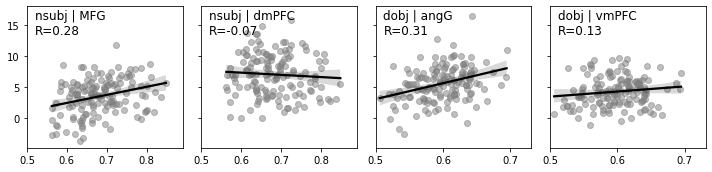

In [6]:
titles=['nsubj | MFG','nsubj | dmPFC','dobj | angG','dobj | vmPFC']
locs=[(3,4),(3,7),(5,2),(5,6)]
annotate_locs=[(0.55,10),(0.55,14),(0.5,14),(0.49,8.5)]
fig,axarr=plt.subplots(ncols=4,figsize=(10,2.5),sharex=False,sharey=True)
for i in range(4):
    loc=locs[i]
    x=headwise_corr_data[loc[0],loc[1],:,0]
    y=headwise_corr_data[loc[0],loc[1],:,1]   
    title=titles[i]+"\n"+"R="+str(np.round(spearmanr(x,y)[0],2))
    sns.regplot(x,y,color='black',ax=axarr[i],scatter_kws={'color':'grey','alpha':0.5},line_kws={'color':'black'})
    axarr[i].annotate(title,(0.05,0.8),xycoords='axes fraction',fontsize=12)
    axarr[i].set_xlim(left=0.5)
    if i<2:
        axarr[i].set_xticks([0.5,0.6,0.7,0.8])
    else:
        axarr[i].set_xticks([0.5,0.6,0.7])
fig.tight_layout()
plt.savefig('scatterplots.svg',format='svg')



In [6]:
headwise_corr_data.shape 

(12, 10, 144, 2)

In [10]:
deps=[]
roi_names=[]
brain_encoding=[]
dep_decoding=[]
for i in range(12):
    for j in range(10):
        for k in range(144):
            dep_decoding.append(headwise_corr_data[i,j,:,0][k])
            brain_encoding.append(headwise_corr_data[i,j,:,1][k])
            deps.append(dependencies[i])
            roi_names.append(rois[j])
df=pd.DataFrame(dict(dependencies=deps,rois=roi_names,brain_encoding=brain_encoding,dependency_decoding=dep_decoding))
df 
        

,dependencies,rois,brain_encoding,dependency_decoding
0,prep,PostTemp,10.119623,0.605888
1,prep,PostTemp,13.486211,0.592030
2,prep,PostTemp,13.304593,0.748380
3,prep,PostTemp,12.810634,0.680443
4,prep,PostTemp,10.934491,0.588833
...,...,...,...,...
17275,prt,HG,6.362470,0.524196
17276,prt,HG,6.443092,0.612273
17277,prt,HG,8.149585,0.574166
17278,prt,HG,10.250457,0.547319


In [31]:
roi_order=['HG','PostTemp','AntTemp','AngG','IFG','IFGorb','MFG','vmPFC','dmPFC','PMC']




((144,), (144,))

/usr/people/sreejank/anaconda3/envs/fmri/lib/python3.7/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


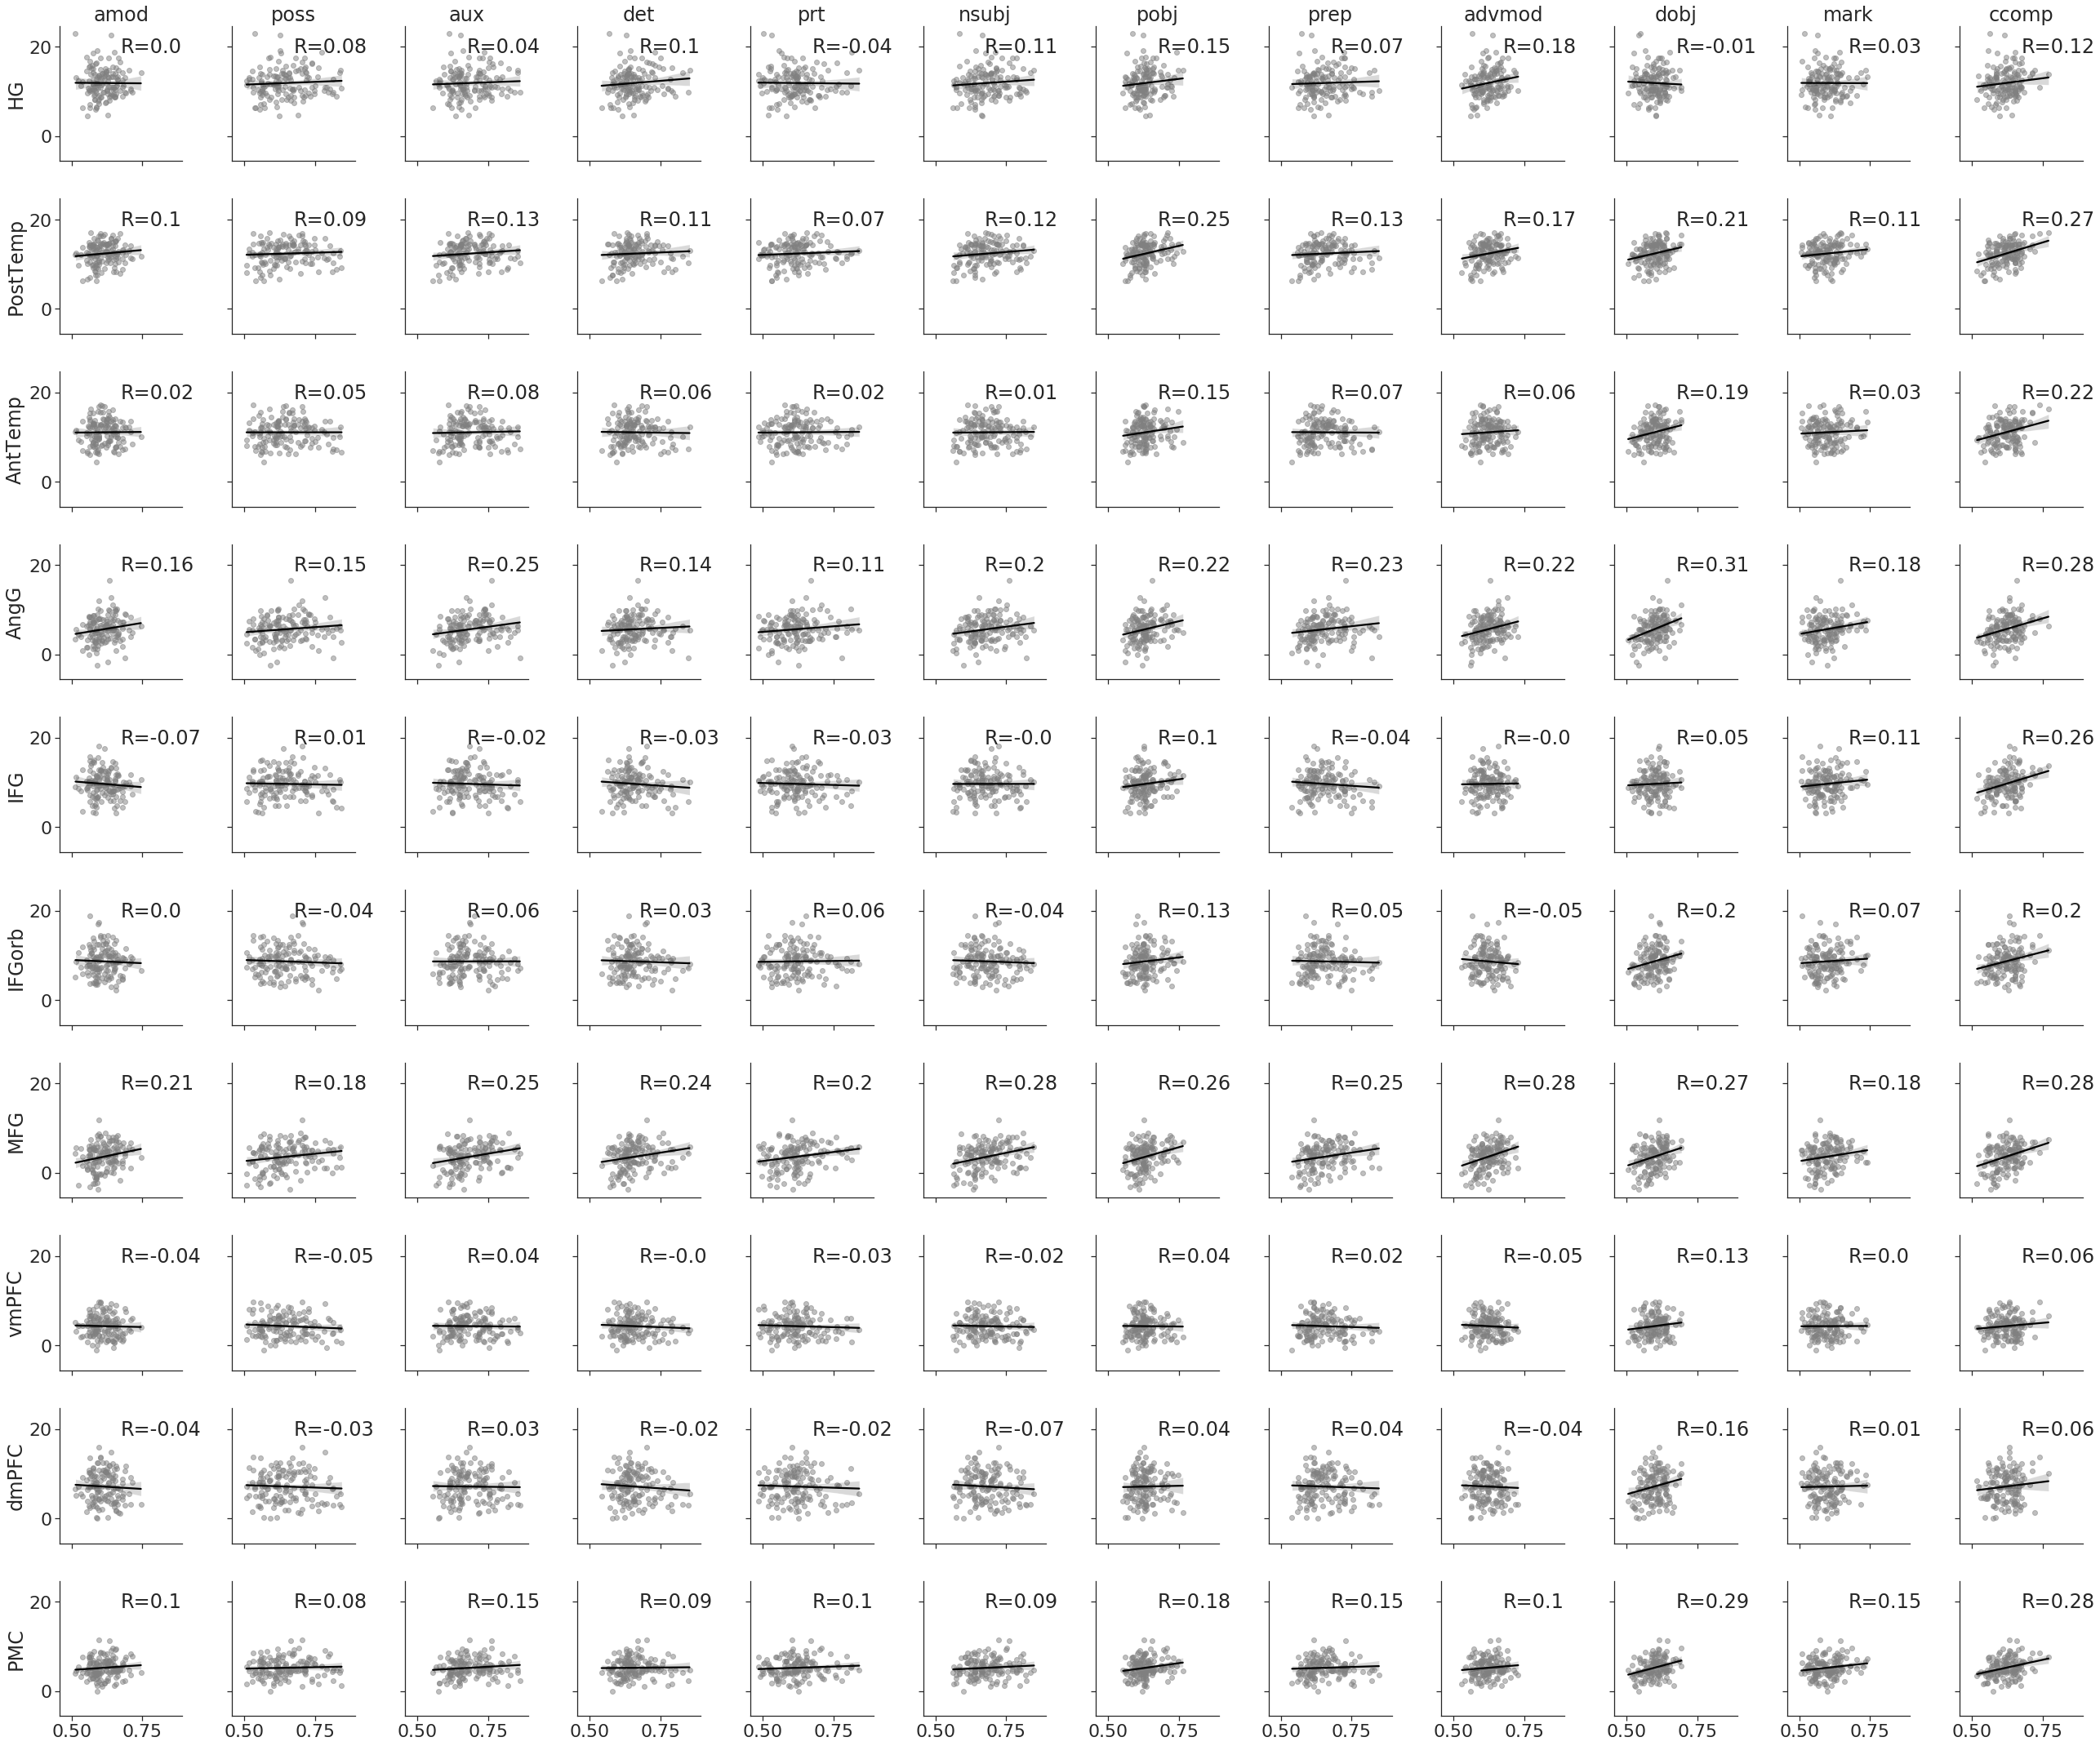

In [38]:
roi_order=['HG','PostTemp','AntTemp','AngG','IFG','IFGorb','MFG','vmPFC','dmPFC','PMC']
sns.set(font_scale=2,style='ticks')
g=sns.FacetGrid(df,col='dependencies',row='rois',row_order=['HG','PostTemp','AntTemp','AngG','IFG','IFGorb','MFG','vmPFC','dmPFC','PMC'],col_order=dependencies2)
g.map_dataframe(sns.regplot,'dependency_decoding','brain_encoding',scatter_kws={'color':'grey','alpha':0.5},line_kws={'color':'black'})
for j in range(len(g.axes)):
    for i in range(len(g.axes[j])):
        x=df[(df.dependencies==dependencies2[i]) & (df.rois==roi_order[j])]['dependency_decoding']
        y=df[(df.dependencies==dependencies2[i]) & (df.rois==roi_order[j])]['brain_encoding']
        title="R="+str(np.round(spearmanr(x,y)[0],2))
        g.axes[j][i].annotate(title,(0.5,0.8),xycoords='axes fraction',fontsize=24)
        g.axes[j][i].set_title('')
        if j==0:
            g.axes[j][i].set_title(dependencies2[i])
        if i==0:
            g.axes[j][i].set_ylabel(roi_order[j])
        g.axes[j][i].set_xlabel('')
plt.savefig('big_scatterplots.svg',format='svg')

/usr/people/sreejank/anaconda3/envs/fmri/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


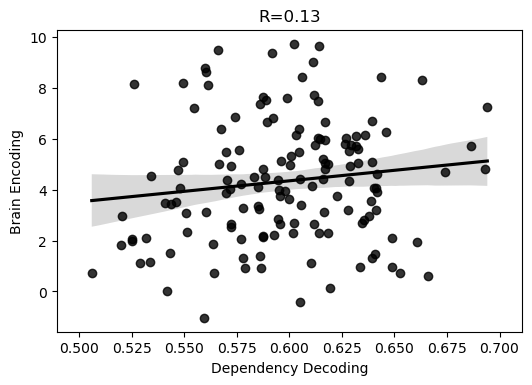

In [21]:
x=headwise_corr_data[5,6,:,0]
y=headwise_corr_data[5,6,:,1]
x=x[x>-9999]
y=y[y>-9999]
plt.figure(dpi=100)
sns.regplot(x,y,color='black')
plt.ylabel("Brain Encoding")
plt.xlabel("Dependency Decoding")
plt.title("R="+str(np.round(spearmanr(x,y)[0],2)))
plt.savefig('dobj_vmPFC.svg',format='svg')

In [22]:
roi=[]
dependency=[]
encoding_performance=[]
decoding_performance=[]
for r in range(10):
    for d in range(len(dependencies)):
        for i in range(144):
            roi.append(rois[r])
            dependency.append(dependencies[d])
            decoding_performance.append(headwise_corr_data[d,r,i,0])
            encoding_performance.append(headwise_corr_data[d,r,i,1])
roi=np.asarray(roi)
dependency=np.asarray(dependency)
encoding_performance=np.asarray(encoding_performance)
decoding_performance=np.asarray(decoding_performance)
df=pd.DataFrame(dict(roi=roi,dependency=dependency,encoding_performance=encoding_performance,decoding_performance=decoding_performance))
df 

,roi,dependency,encoding_performance,decoding_performance
0,PostTemp,prep,10.119623,0.605888
1,PostTemp,prep,13.486211,0.592030
2,PostTemp,prep,13.304593,0.748380
3,PostTemp,prep,12.810634,0.680443
4,PostTemp,prep,10.934491,0.588833
...,...,...,...,...
17275,HG,prt,6.362470,0.524196
17276,HG,prt,6.443092,0.612273
17277,HG,prt,8.149585,0.574166
17278,HG,prt,10.250457,0.547319


In [21]:
x=headwise_corr_data[5,6,:,0]
y=headwise_corr_data[5,6,:,1]
x=x[x>-9999]
y=y[y>-9999]
plt.figure(dpi=100)
sns.regplot(x,y,color='black')
plt.ylabel("Brain Encoding")
plt.xlabel("Dependency Decoding")
plt.title("R="+str(np.round(spearmanr(x,y)[0],2)))
plt.savefig('dobj_vmPFC.svg',format='svg')

['PostTemp',
 'AntTemp',
 'AngG',
 'IFG',
 'MFG',
 'IFGorb',
 'vmPFC',
 'dmPFC',
 'PMC',
 'HG',
 'V1']

In [24]:
plt.figure(dpi=250)
g=sns.FacetGrid(data=df,row='roi',col='dependency')
g.map_dataframe(sns.regplot,x='decoding_performance',y='encoding_performance',scatter_kws={"color": "grey"}, line_kws={"color": "black"})
for r in range(10):
    for d in range(12):
        correlation,p=spearmanr(headwise_corr_data[d,r,:,0],headwise_corr_data[d,r,:,1])
        g.axes[r,d].text(0.8,20,"R="+str(np.round(correlation,2)))
plt.savefig('matt_corrs.png',format='png')

<Figure size 1500x1000 with 0 Axes>

In [19]:
dep_order 

array([ 4,  8,  7,  2, 11,  3,  1,  0,  6,  5, 10,  9])

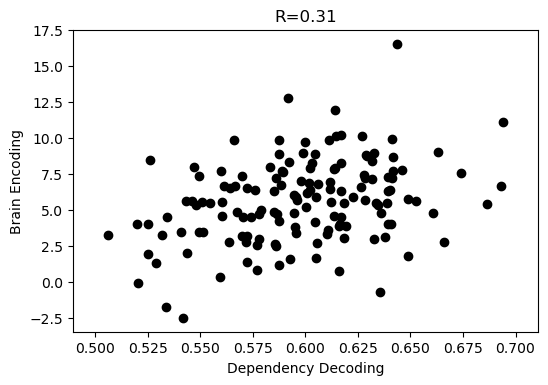

In [8]:
x=headwise_corr_data[5,2,:,0]
y=headwise_corr_data[5,2,:,1]
x=x[x>-9999]
y=y[y>-9999]
plt.figure(dpi=100)
plt.scatter(x,y,c='black')
plt.ylabel("Brain Encoding")
plt.xlabel("Dependency Decoding")
plt.title("R="+str(np.round(spearmanr(x,y)[0],2)))
plt.savefig('dobj_angG.svg',format='svg')


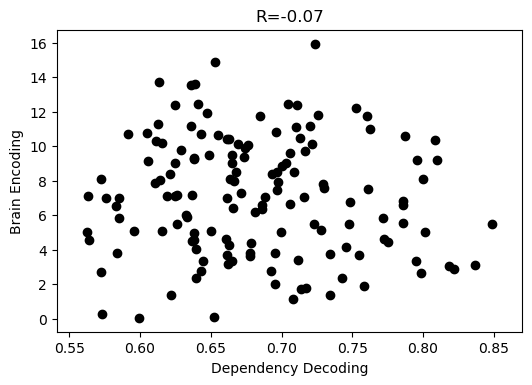

In [9]:
x=headwise_corr_data[3,7,:,0]
y=headwise_corr_data[3,7,:,1]
x=x[x>-9999]
y=y[y>-9999]
plt.figure(dpi=100)
plt.scatter(x,y,c='black')
plt.ylabel("Brain Encoding")
plt.xlabel("Dependency Decoding")
plt.title("R="+str(np.round(spearmanr(x,y)[0],2)))
plt.savefig('dmPFC_nsubj.svg',format='svg')


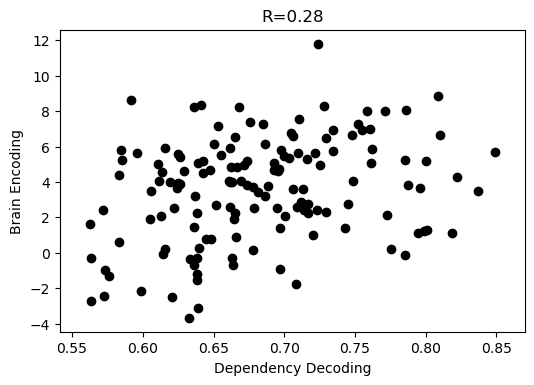

In [22]:
x=headwise_corr_data[3,4,:,0]
y=headwise_corr_data[3,4,:,1]
x=x[x>-9999]
y=y[y>-9999]
plt.figure(dpi=100)
plt.scatter(x,y,c='black')
plt.ylabel("Brain Encoding")
plt.xlabel("Dependency Decoding")
plt.title("R="+str(np.round(spearmanr(x,y)[0],2)))
plt.savefig('dmPFC_nsubj.svg',format='svg')


/usr/people/sreejank/anaconda3/envs/fmri/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


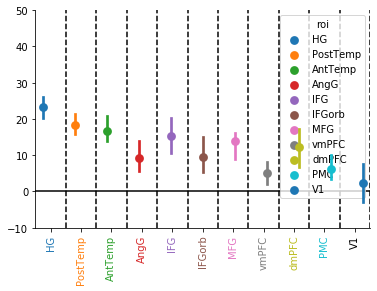

In [9]:
results=[]
dataset=['black','slumlordreach']
normalize_isc=True 
for story in dataset:
    results_story=[]
    if story=='black':
        subs=black_subs
    if story=='slumlordreach':
        subs=slumlordreach_subs
    result_dir='/jukebox/griffiths/bert-brains/results/'+story+"/encoding-zrep_magnitudes/"
    roi_mapping=np.load('/jukebox/griffiths/bert-brains/'+story+'_data/Parcel2ROI_new.npy')
    for sub in subs:
        #results_sub_parcels=np.load(result_dir+sub+"_parcelwise_results.npy")
        #noise_ceiling_parcels=np.load('/jukebox/griffiths/bert-brains/'+story+"_data/isc/"+sub+'.npy')

        results_sub_parcels=np.arctanh(np.load(result_dir+sub+"_parcelwise_results.npy"))
        noise_ceiling_parcels=np.arctanh(np.load('/jukebox/griffiths/bert-brains/'+story+"_data/isc/"+sub+'.npy'))
        results_sub_parcels[np.isnan(results_sub_parcels)]=0.0
        noise_ceiling_parcels[np.isnan(noise_ceiling_parcels)]=0.0
        results_sub=np.zeros((22,))
        noise_sub=np.zeros((22,))
        
        for roi in range(22):
            results_sub[roi]=results_sub_parcels[np.where(roi_mapping==roi+1)].mean() 
            noise_sub[roi]=noise_ceiling_parcels[np.where(roi_mapping==roi+1)].mean()
        #results_story.append(-1*np.log(results_sub/noise_sub))
        if normalize_isc:
            r=(results_sub/noise_sub)*100.0 
            r[r>100.0]=100.0
            results_story.append((results_sub/noise_sub)*100.0)
        else:
            results_story.append((results_sub))
    results_story=np.asarray(results_story)
    results.append(results_story)
results=np.asarray(results)
results=np.concatenate(results,axis=0)
results[np.isnan(results)]=0.0



roi=[]
performance=[]
for i in range(results.shape[0]):
    for j in range(11):
        roi.append(rois[j])
        performance.append(results[i,j])
df=pd.DataFrame(dict(roi=roi,performance=performance))
pal=sns.mpl_palette('tab10',n_colors=10)

#v=sns.violinplot(data=df,x='roi',y='performance',zorder=0,inner=None,linewidth=1,cut=0,hue='roi',alpha=0.2)
#sns.stripplot(data=df.sort_values('performance'),x='roi',y='performance',hue='rep',dodge=0.5,zorder=1,size=2,palette=pal2,order=['HG','PostTemp','AntTemp','AngG','IFG',
#'IFGorb','MFG','vmPFC','dmPFC','PMC'],alpha=0.1,hue_order=rep_names)
sns.pointplot(data=df.sort_values('performance'),x='roi',y='performance',hue='roi',dodge=0.5,join=False,ci=95,n_boot=10000,zorder=2,alpha=0.5,palette=pal,order=['HG','PostTemp','AntTemp','AngG','IFG',
'IFGorb','MFG','vmPFC','dmPFC','PMC','V1'],capsize=0,estimator=np.median,hue_order=['HG','PostTemp','AntTemp','AngG','IFG',
'IFGorb','MFG','vmPFC','dmPFC','PMC','V1'])
#sns.boxplot(x='roi',y='performance',data=df,saturation=0.35,fliersize=0)
plt.xticks(rotation=90)
#plt.legend(['L','R'],['C0','C1'])
plt.axhline(y=0,color='black')
ax=plt.gca()
#handles, labels = ax.get_legend_handles_labels()
#ax.legend(handles[:6], labels[:])
sns.despine(top=True,right=True,left=False,bottom=False)
my_colors=['C'+str(i) for i in range(10)]
for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), my_colors):
    ticklabel.set_color(tickcolor)
plt.xlabel("")
plt.ylabel("")
plt.ylim(-10,50)
for i in range(11):
    plt.axvline(x=i+0.5,color='black',linestyle='--')
 

/usr/people/sreejank/anaconda3/envs/fmri/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


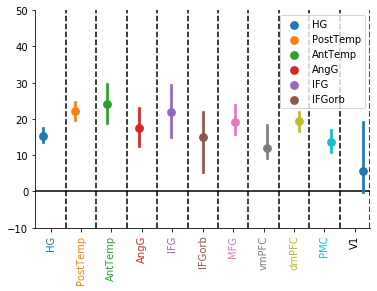

In [10]:
results2=[]
dataset=['black','slumlordreach']
normalize_isc=True 
for story in dataset:
    results_story=[]
    if story=='black':
        subs=black_subs
    if story=='slumlordreach':
        subs=slumlordreach_subs
    result_dir='/jukebox/griffiths/bert-brains/results/'+story+"/encoding_full_z/"
    roi_mapping=np.load('/jukebox/griffiths/bert-brains/'+story+'_data/Parcel2ROI_new.npy')
    for sub in subs:
        #results_sub_parcels=np.load(result_dir+sub+"_parcelwise_results.npy")
        #noise_ceiling_parcels=np.load('/jukebox/griffiths/bert-brains/'+story+"_data/isc/"+sub+'.npy')

        results_sub_parcels=np.arctanh(np.load(result_dir+sub+"_parcelwise_results.npy"))
        noise_ceiling_parcels=np.arctanh(np.load('/jukebox/griffiths/bert-brains/'+story+"_data/isc/"+sub+'.npy'))
        results_sub_parcels[np.isnan(results_sub_parcels)]=0.0
        noise_ceiling_parcels[np.isnan(noise_ceiling_parcels)]=0.0
        results_sub=np.zeros((22,))
        noise_sub=np.zeros((22,))
        
        for roi in range(22):
            results_sub[roi]=results_sub_parcels[np.where(roi_mapping==roi+1)].mean() 
            noise_sub[roi]=noise_ceiling_parcels[np.where(roi_mapping==roi+1)].mean()
        #results_story.append(-1*np.log(results_sub/noise_sub))
        if normalize_isc:
            r=(results_sub/noise_sub)*100.0 
            r[r>100.0]=100.0
            results_story.append((results_sub/noise_sub)*100.0)
        else:
            results_story.append((results_sub))
    results_story=np.asarray(results_story)
    results2.append(results_story)
results2=np.asarray(results2)
results2=np.concatenate(results2,axis=0)
results2[np.isnan(results2)]=0.0



roi=[]
performance=[]
for i in range(results.shape[0]):
    for j in range(11):
        roi.append(rois[j])
        performance.append(results2[i,j])
df=pd.DataFrame(dict(roi=roi,performance=performance))
pal=sns.mpl_palette('tab10',n_colors=10)

#v=sns.violinplot(data=df,x='roi',y='performance',zorder=0,inner=None,linewidth=1,cut=0,hue='roi',alpha=0.2)
#sns.stripplot(data=df.sort_values('performance'),x='roi',y='performance',hue='rep',dodge=0.5,zorder=1,size=2,palette=pal2,order=['HG','PostTemp','AntTemp','AngG','IFG',
#'IFGorb','MFG','vmPFC','dmPFC','PMC'],alpha=0.1,hue_order=rep_names)
sns.pointplot(data=df.sort_values('performance'),x='roi',y='performance',hue='roi',dodge=0.5,join=False,ci=95,n_boot=10000,zorder=2,alpha=0.5,palette=pal,order=['HG','PostTemp','AntTemp','AngG','IFG',
'IFGorb','MFG','vmPFC','dmPFC','PMC','V1'],capsize=0,estimator=np.median,hue_order=['HG','PostTemp','AntTemp','AngG','IFG',
'IFGorb','MFG','vmPFC','dmPFC','PMC','V1'])
#sns.boxplot(x='roi',y='performance',data=df,saturation=0.35,fliersize=0)
plt.xticks(rotation=90)
#plt.legend(['L','R'],['C0','C1'])
plt.axhline(y=0,color='black')
ax=plt.gca()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:6], labels[:])
sns.despine(top=True,right=True,left=False,bottom=False)
my_colors=['C'+str(i) for i in range(10)]
for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), my_colors):
    ticklabel.set_color(tickcolor)
plt.xlabel("")
plt.ylabel("")
plt.ylim(-10,50)
for i in range(11):
    plt.axvline(x=i+0.5,color='black',linestyle='--')
 

Text(0.5, 1.0, 'Performance of Transformations on Attention Score Residual Minus Performance of Attention Scores on Transformation Residuals')

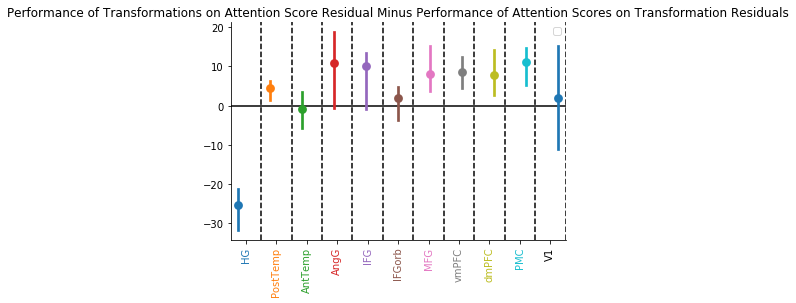

In [35]:

roi=[]
performance=[]
for i in range(results.shape[0]):
    for j in range(11):
        roi.append(rois[j])
        performance.append(results[i,j]-results2[i,j])
df=pd.DataFrame(dict(roi=roi,performance=performance))
pal=sns.mpl_palette('tab10',n_colors=10)

#v=sns.violinplot(data=df,x='roi',y='performance',zorder=0,inner=None,linewidth=1,cut=0,hue='roi',alpha=0.2)
#sns.stripplot(data=df.sort_values('performance'),x='roi',y='performance',hue='rep',dodge=0.5,zorder=1,size=2,palette=pal2,order=['HG','PostTemp','AntTemp','AngG','IFG',
#'IFGorb','MFG','vmPFC','dmPFC','PMC'],alpha=0.1,hue_order=rep_names)
sns.pointplot(data=df.sort_values('performance'),x='roi',y='performance',hue='roi',dodge=0.5,join=False,ci=95,n_boot=10000,zorder=2,alpha=0.5,palette=pal,order=['HG','PostTemp','AntTemp','AngG','IFG',
'IFGorb','MFG','vmPFC','dmPFC','PMC','V1'],capsize=0,estimator=np.median,hue_order=['HG','PostTemp','AntTemp','AngG','IFG',
'IFGorb','MFG','vmPFC','dmPFC','PMC','V1'])
#sns.boxplot(x='roi',y='performance',data=df,saturation=0.35,fliersize=0)
plt.xticks(rotation=90)
#plt.legend(['L','R'],['C0','C1'])
plt.axhline(y=0,color='black')
ax=plt.gca()
handles, labels = ax.get_legend_handles_labels()
ax.legend([])
sns.despine(top=True,right=True,left=False,bottom=False)
my_colors=['C'+str(i) for i in range(10)]
for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), my_colors):
    ticklabel.set_color(tickcolor)
plt.xlabel("")
plt.ylabel("")
for i in range(11):
    plt.axvline(x=i+0.5,color='black',linestyle='--')
plt.title("Performance of Transformations on Attention Score Residual Minus Performance of Attention Scores on Transformation Residuals")

In [30]:
results==results2

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [36]:
results=[]
dataset=['black','slumlordreach']
normalize_isc=True 
for story in dataset:
    results_story=[]
    if story=='black':
        subs=black_subs
    if story=='slumlordreach':
        subs=slumlordreach_subs
    result_dir='/jukebox/griffiths/bert-brains/results/'+story+"/encoding_zrep_magnitudes/"
    roi_mapping=np.load('/jukebox/griffiths/bert-brains/'+story+'_data/Parcel2ROI_new.npy')
    for sub in subs:
        #results_sub_parcels=np.load(result_dir+sub+"_parcelwise_results.npy")
        #noise_ceiling_parcels=np.load('/jukebox/griffiths/bert-brains/'+story+"_data/isc/"+sub+'.npy')

        results_sub_parcels=np.arctanh(np.load(result_dir+sub+"_parcelwise_results.npy"))
        noise_ceiling_parcels=np.arctanh(np.load('/jukebox/griffiths/bert-brains/'+story+"_data/isc/"+sub+'.npy'))
        results_sub_parcels[np.isnan(results_sub_parcels)]=0.0
        noise_ceiling_parcels[np.isnan(noise_ceiling_parcels)]=0.0
        results_sub=results_sub_parcels
        noise_sub=noise_ceiling_parcels
        
        #results_story.append(-1*np.log(results_sub/noise_sub))
        if normalize_isc:
            r=(results_sub/noise_sub)*100.0 
            r[r>100.0]=100.0
            results_story.append(r)
        else:
            results_story.append((results_sub))
    results_story=np.asarray(results_story)
    results.append(results_story)
results=np.asarray(results2)
results=np.concatenate(results2,axis=0)
results[np.isnan(results2)]=0.0

results2=[]
dataset=['black','slumlordreach']
normalize_isc=True 
for story in dataset:
    results_story=[]
    if story=='black':
        subs=black_subs
    if story=='slumlordreach':
        subs=slumlordreach_subs
    result_dir='/jukebox/griffiths/bert-brains/results/'+story+"/encoding_full_z/"
    roi_mapping=np.load('/jukebox/griffiths/bert-brains/'+story+'_data/Parcel2ROI_new.npy')
    for sub in subs:
        #results_sub_parcels=np.load(result_dir+sub+"_parcelwise_results.npy")
        #noise_ceiling_parcels=np.load('/jukebox/griffiths/bert-brains/'+story+"_data/isc/"+sub+'.npy')

        results_sub_parcels=np.arctanh(np.load(result_dir+sub+"_0_parcelwise_results.npy"))
        noise_ceiling_parcels=np.arctanh(np.load('/jukebox/griffiths/bert-brains/'+story+"_data/isc/"+sub+'.npy'))
        results_sub_parcels[np.isnan(results_sub_parcels)]=0.0
        noise_ceiling_parcels[np.isnan(noise_ceiling_parcels)]=0.0
        results_sub=results_sub_parcels
        noise_sub=noise_ceiling_parcels
        
        #results_story.append(-1*np.log(results_sub/noise_sub))
        if normalize_isc:
            r=(results_sub/noise_sub)*100.0 
            r[r>100.0]=100.0
            results_story.append(r)
        else:
            results_story.append((results_sub))
    results_story=np.asarray(results_story)
    results2.append(results_story)
results2=np.asarray(results2)
results2=np.concatenate(results2,axis=0)
results2[np.isnan(results2)]=0.0

/usr/people/sreejank/anaconda3/envs/fmri/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [43]:
p_values=[]
for i in range(1000):
    if i%100==0:
        print(i)
    p_values.append(bootstrap_pvalue(results2[:,i]))

0
100
200
300
400
500
600
700
800
900


In [44]:
p_values=p_adjust_bh(np.asarray(p_values))


In [48]:
values=np.mean(results2,axis=0)
parcellation_nii=nib.load('/jukebox/griffiths/bert-brains/black_data/Schaefer1000_3mm.nii.gz')
parcellation=parcellation_nii.get_fdata().astype('int')
volume=np.zeros(parcellation.shape)
for p in range(1000):
    if p_values[p]<.05:
        volume[np.where(parcellation==p+1)]=values[p]

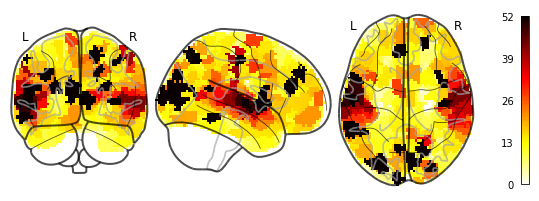

In [51]:
niplt.plot_glass_brain(nib.Nifti1Image(volume,parcellation_nii.affine),colorbar=True)

In [53]:
black_subs=['sub-300', 'sub-304', 'sub-293', 'sub-273', 'sub-265', 'sub-307', 'sub-283', 'sub-275', 
'sub-291', 'sub-297', 'sub-303', 'sub-294', 'sub-286', 'sub-282', 'sub-310', 'sub-302', 'sub-312', 
'sub-301', 'sub-287', 'sub-298', 'sub-313', 'sub-285', 'sub-292', 'sub-311', 'sub-267', 'sub-295', 
'sub-305', 'sub-274', 'sub-290', 'sub-288', 'sub-281', 'sub-276', 'sub-277', 'sub-299', 'sub-308',
 'sub-272', 'sub-284', 'sub-289', 'sub-280', 'sub-309', 'sub-306', 'sub-296', 'sub-127', 'sub-279', 
 'sub-315', 'sub-314']
slumlordreach_subs=['sub-145', 'sub-143', 'sub-016', 'sub-142', 'sub-141', 'sub-133', 'sub-140', 'sub-136', 
'sub-084', 'sub-135', 'sub-137', 'sub-138', 'sub-111', 'sub-106', 'sub-134', 'sub-132', 'sub-144']
dataset=['black','slumlordreach']
results_sub_parcels=[]
for story in dataset:
    if story=='black':
        subs=black_subs
    if story=='slumlordreach':
        subs=slumlordreach_subs
    for sub in subs:
        results_sub_parcels.append(np.load('/jukebox/griffiths/bert-brains/'+story+"_data/isc/"+sub+'.npy'))
results_sub_parcels=np.asarray(results_sub_parcels)
noise_ceilings_parcels=np.mean(results_sub_parcels,axis=0)
parcellation_nii=nib.load('/jukebox/griffiths/bert-brains/slumlordreach_data/Schaefer1000_3mm.nii.gz')
parcellation=parcellation_nii.get_fdata().astype('int')
noise_volume=np.zeros(parcellation.shape)
for p in range(1000):
    noise_volume[np.where(parcellation==p+1)]=np.arctanh(noise_ceilings_parcels[p])

In [54]:
d="/jukebox/griffiths/bert-brains/"
#mask=nib.load(d+"21styear_data/whole_brain_mask.nii.gz").get_fdata().astype('bool')
def get_result_combined(result_dir,threshold=0.95):
    nii=nib.load(result_dir+"two_story_combined_mean.nii.gz")
    affine=nii.affine
    result_volume=nii.get_fdata()
    if threshold>0:
        p_value_nii=nib.load(result_dir+"combined_bootstrap_pvalue_parcellation.nii.gz")
        p_value_volume=p_value_nii.get_fdata()
        binary_volume=p_value_volume>=threshold
        result_volume=result_volume*binary_volume
        result_volume=(np.arctanh(result_volume)/noise_volume)*100.0
        result_volume[np.isnan(result_volume)]=0.0
    return nib.Nifti1Image(result_volume,affine)

In [61]:
layer_names=['layer_'+str(i)+"_z_representations" for i in range(0,12)] 
#layer_names=['layer_'+str(i)+"_activations" for i in range(0,12)] 
save_prefix=d+"results/slumlordreach/"
save_dirs=[save_prefix+"encoding-"+layer+"/" for layer in layer_names]
result_dirs=save_dirs
stacks=np.zeros((65,77,49,12))
for i,result_dir in enumerate(result_dirs):
    nii=get_result_combined(result_dir,threshold=0.95)
    affine=nii.affine 
    stacks[:,:,:,i]=nii.get_fdata()
nib.save(nib.Nifti1Image(stacks,affine),'zwise_sig_results')

/usr/people/sreejank/anaconda3/envs/fmri/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


In [62]:
#layer_names=['layer_'+str(i)+"_z_representations" for i in range(0,12)] 
layer_names=['layer_'+str(i)+"_activations" for i in range(0,12)] 
save_prefix=d+"results/slumlordreach/"
save_dirs=[save_prefix+"encoding-"+layer+"/" for layer in layer_names]
result_dirs=save_dirs
stacks=np.zeros((65,77,49,12))
for i,result_dir in enumerate(result_dirs):
    nii=get_result_combined(result_dir,threshold=0.95)
    affine=nii.affine 
    stacks[:,:,:,i]=nii.get_fdata()
nib.save(nib.Nifti1Image(stacks,affine),'layerwise_sig_results')

/usr/people/sreejank/anaconda3/envs/fmri/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


In [65]:
x=nib.load('layerwise_sig_results.nii').get_fdata()
y=nib.load('zwise_sig_results.nii').get_fdata()

In [13]:
dependencies=['prep','pobj','det','nsubj','amod','dobj','advmod','aux','poss','ccomp','mark','prt']

In [23]:
dependency=[]
n_TRs=[]
story=[]

for d in dependencies:
    n_TRs.append(np.sum(np.load('data/black/'+d+".npy")))
    story.append('Black')
    dependency.append(d)
for d in dependencies:
    n_TRs.append(np.sum(np.load('data/slumlordreach/'+d+".npy")[:619]))
    story.append('Slumlord')
    dependency.append(d)
import pandas as pd 
df=pd.DataFrame(dict(dependency=dependency,n_TRs=n_TRs,story=story))
df 

,dependency,n_TRs,story
0,prep,121,Black
1,pobj,109,Black
2,det,117,Black
3,nsubj,245,Black
4,amod,43,Black
5,dobj,95,Black
6,advmod,122,Black
7,aux,99,Black
8,poss,35,Black
9,ccomp,46,Black


In [22]:
np.load('data/slumlordreach/'+d+".npy").shape

(1177,)

In [17]:
for d in dependencies:
    print(np.sum(np.load('data/slumlordreach/'+d+".npy")[:619]))

214
195
206
392
66
153
177
150
45
61
35
29


In [18]:
29/619

0.046849757673667204